In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-01-02 22:37:01.797375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 22:37:01.805891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735857421.814855 2474083 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735857421.817476 2474083 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 22:37:01.828349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def load_pickle(file_path):
    try:
        print(f"Loading: {file_path}")
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
path_afib_aflt = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_afib_aflt.pkl'
path_norm = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_norm.pkl'
path_y_afib_aflt = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_afib_aflt.pkl'
path_y_norm = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_norm.pkl'

X_afib_aflt = load_pickle(path_afib_aflt)
X_norm = load_pickle(path_norm)
Y_afib_aflt = load_pickle(path_y_afib_aflt)
Y_norm = load_pickle(path_y_norm)
if X_afib_aflt is not None:
    print("X_afib_aflt:", type(X_afib_aflt), len(X_afib_aflt))
if X_norm is not None:
    print("X_norm:", type(X_norm), len(X_norm))
if Y_afib_aflt is not None:
    print("Y_afib_aflt:", type(Y_afib_aflt), len(Y_afib_aflt))
if Y_norm is not None:
    print("Y_norm:", type(Y_norm), len(Y_norm))

Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_afib_aflt.pkl
Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_norm.pkl


Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_afib_aflt.pkl
Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_norm.pkl
X_afib_aflt: <class 'numpy.ndarray'> 1570
X_norm: <class 'numpy.ndarray'> 9069
Y_afib_aflt: <class 'pandas.core.frame.DataFrame'> 1570
Y_norm: <class 'pandas.core.frame.DataFrame'> 9069


In [3]:
labels_norm = np.array([row for row in Y_norm['diagnostic_superclass']])

#  Randomly select 2000 samples
num_samples = 2000
random_indices = np.random.choice(len(X_norm), num_samples, replace=False)

norm_ecgs = X_norm[random_indices]
norm_labels = labels_norm[random_indices]
Y_afib_aflt = Y_afib_aflt[["diagnostic_superclass"]]
Y_afib_aflt["diagnostic_superclass"] = "AF"
Y_afib_aflt = Y_afib_aflt.to_numpy().reshape(-1, 1)
ecg_signals = np.concatenate((norm_ecgs, X_afib_aflt), axis=0)

ecgs_labels = np.concatenate((norm_labels, Y_afib_aflt), axis=0)

print(f"Combined ECG signals shape: {ecg_signals.shape}")
print(f"Combined labels shape: {ecgs_labels.shape}")

Combined ECG signals shape: (3570, 1000, 12)
Combined labels shape: (3570, 1)


In [4]:
# Use only Lead II (second column of ECG signals)
lead_II = ecg_signals[:, :, 1:2]  # Shape: (samples, timesteps, 1)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(lead_II.reshape(-1, 1)).reshape(lead_II.shape)
# Median Filtering
window_size = 5
X_filtered = np.array([medfilt(x.squeeze(), kernel_size=window_size) for x in X_normalized])
X_filtered = X_filtered[..., np.newaxis]  # Reshape to (samples, timesteps, 1)
# Segment the signals
segment_length = 1000
X_segmented = np.array([
    x[i:i + segment_length] for x in X_filtered for i in range(0, len(x) - segment_length + 1, segment_length)
])
# Convert 'NORM' to 0 and 'AF' to 1
ecgs_labels_numeric = np.where(ecgs_labels == 'NORM', 0, 1)

# Step 1: Split into training (64%) and temporary (36%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X_segmented, ecgs_labels_numeric, 
                                                    test_size=0.36, random_state=42, 
                                                    stratify=ecgs_labels)

# Step 2: Split the temporary dataset into validation (25%) and test (20%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.5556, random_state=42, 
                                                stratify=y_temp)

# Step 3: Verify the class distributions in each dataset
print("Training set class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Validation set class distribution:", dict(zip(*np.unique(y_val, return_counts=True))))
print("Test set class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Training set class distribution: {np.int64(0): np.int64(1280), np.int64(1): np.int64(1004)}
Validation set class distribution: {np.int64(0): np.int64(320), np.int64(1): np.int64(251)}
Test set class distribution: {np.int64(0): np.int64(400), np.int64(1): np.int64(315)}


In [5]:
mean = np.mean(X_train, axis=(0, 1))
std = np.std(X_train, axis=(0, 1))
ECGs = (X_train - mean) / std
mean_v = np.mean(X_val, axis=(0, 1))
std_v = np.std(X_val, axis=(0, 1))
ECGs_val = (X_val - mean_v) / std_v
mean_t = np.mean(X_test, axis=(0, 1))
std_t = np.std(X_test, axis=(0, 1))
ECGs_test= (X_test - mean_t) / std_t

In [6]:
def compare_real_and_gen_ecg(generated_ecg, ECGs):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24, 4))
    
    # Plot generated ECG
    plt.subplot(1, 2, 1)
    plt.title("Generated (fake) ECG", fontsize=16)
    plt.plot(generated_ecg[0, :, 0])  # Assuming 1 lead (index 0)
    
    # Plot real ECG
    plt.subplot(1, 2, 2)
    plt.title("Real ECG", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx, :, 0])  # Assuming 1 lead (index 0)
    
    plt.show()
def generate_latent_points(latent_dim, n_samples):
    x_latent = np.random.randn(n_samples, latent_dim)
    return x_latent
def generate_fake_samples(latent_dim, generator, n):
    x_input = generate_latent_points(latent_dim, n)
    labels = np.random.randint(0, 2, n)
    labels = np.expand_dims(labels, axis=-1)
    X = generator.predict([x_input, labels], verbose=0)
    y = np.zeros((n, 1))
    return X, y

def generate_real_samples(ecgsignal, y_train, n):
    indices = np.random.choice(min(ecgsignal.shape[0], y_train.shape[0]), n, replace=False)
    X = ecgsignal[indices]
    y = y_train[indices]
    y = np.expand_dims(y, axis=-1) if len(y.shape) == 1 else y
    return X, y
def smooth_positive_labels(y):
    return y - 0.05 + (tf.random.uniform(y.shape) * 0.1)
def smooth_negative_labels(y):
    return y + (tf.random.uniform(y.shape) * 0.1)

# Updated Gradient Penalty Layer
class GradientPenaltyLayer(tf.keras.layers.Layer):
    def __init__(self, discriminator, **kwargs):
        super(GradientPenaltyLayer, self).__init__(**kwargs)
        self.discriminator = discriminator

    def call(self, real, fake, labels_tensor):
        alpha = tf.random.uniform([real.shape[0], 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels_tensor])
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-10)
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty
def temporal_coherence_loss(real_data, generated_data):
    diff_real = real_data[:, 1:, :] - real_data[:, :-1, :]
    diff_fake = generated_data[:, 1:, :] - generated_data[:, :-1, :]
    return tf.reduce_mean(tf.square(diff_real - diff_fake))

In [7]:
def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=16,  # Reduce bottleneck size
    nb_filters=16,       # Reduce the number of filters
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # Simplify kernel sizes
    kernel_size_s = [kernel_size // (2**i) for i in range(2)]

    conv_list = []

    for i in range(len(kernel_size_s)):
         conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)
    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x
def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x
def self_attention_layer(x, filters):
    f = tf.keras.layers.Conv1D(filters // 8, 1, activation='relu')(x)  # Query
    g = tf.keras.layers.Conv1D(filters // 8, 1, activation='relu')(x)  # Key
    h = tf.keras.layers.Conv1D(filters, 1, activation='relu')(x)       # Value

    attention_map = tf.keras.layers.Softmax()(tf.keras.layers.Dot(axes=[2, 2])([f, g]))
    attention_out = tf.keras.layers.Dot(axes=[2, 1])([attention_map, h])

    return tf.keras.layers.Add()([x, attention_out])  # Residual connection

In [8]:
def con_discriminator(input_shape=(1000, 1), depth=4):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    label_input = tf.keras.layers.Input(shape=(1,), dtype='int32')
    
    # Label embedding
    label_embedding = tf.keras.layers.Embedding(2, np.prod(input_shape))(label_input)
    label_embedding = tf.keras.layers.Reshape(input_shape)(label_embedding)
    merged_input = tf.keras.layers.Concatenate(axis=-1)([input_layer, label_embedding])
    
    x = merged_input
    input_res = merged_input
    feature_outputs = []  # Store intermediate features for feature matching loss

    # Add convolutional and residual blocks
    for d in range(depth):
        x = tf.keras.layers.Conv1D(filters=64 * (d + 1), kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        if d % 2 == 1:  # Residual connection every second layer
            x = _shortcut_layer(input_res, x)
            input_res = x
        
        feature_outputs.append(x)  # Store intermediate features
    
    # Global average pooling for classification
    gap = tf.keras.layers.GlobalAveragePooling1D()(x)
    output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(gap)
    
    model = tf.keras.models.Model(inputs=[input_layer, label_input], outputs=[output_layer] + feature_outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
        metrics=['accuracy'],
    )
    return model

In [9]:
def con_generator(latent_dim=12):
    # Inputs: Noise vector and label
    noise_input = tf.keras.layers.Input(shape=(latent_dim,))
    label_input = tf.keras.layers.Input(shape=(1,), dtype='int32')

    # Label embedding and concatenation
    label_embedding = tf.keras.layers.Embedding(2, latent_dim)(label_input)
    label_embedding_flat = tf.keras.layers.Flatten()(label_embedding)
    merged_input = tf.keras.layers.Concatenate(axis=1)([noise_input, label_embedding_flat])

    # Fully connected layer and reshape
    x = tf.keras.layers.Dense(64 * 1000, use_bias=False)(merged_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((1000, 64))(x)  # Reshape to (1000 timesteps, 64 channels)

    # Initial Convolution Layers to extract local features
    x = tf.keras.layers.Conv1D(128, kernel_size=7, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # Dilated Convolutions with varying kernel sizes
    x1 = tf.keras.layers.Conv1D(128, kernel_size=3, dilation_rate=1, padding='same', activation='relu')(x)
    x2 = tf.keras.layers.Conv1D(128, kernel_size=5, dilation_rate=2, padding='same', activation='relu')(x)
    x3 = tf.keras.layers.Conv1D(128, kernel_size=7, dilation_rate=4, padding='same', activation='relu')(x)
    x = tf.keras.layers.Concatenate(axis=-1)([x1, x2, x3])  # Multi-scale feature fusion

    # Debug statement to check the shape before GRU layer
    print(f"Shape before GRU: {x.shape}")  # Debug the shape

    # If the shape is (batch_size, 1000, 384), reduce the number of features (channels) before GRU
    x = tf.keras.layers.Conv1D(128, kernel_size=1, padding='same', activation='relu')(x)  # Adjust channels

    # Recurrent Layer: GRU to capture sequential dependencies
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)

    # Temporal Attention Layer
    query = tf.keras.layers.Dense(256)(x)
    key = tf.keras.layers.Dense(256)(x)
    value = tf.keras.layers.Dense(256)(x)
    attention = tf.keras.layers.Attention()([query, key, value])
    x = tf.keras.layers.Add()([x, attention])  # Residual connection

    # Additional Convolutions for further refinement
    x = tf.keras.layers.Conv1DTranspose(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(32, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # Time Encoding: Adding positional information
    time_encoding = tf.keras.layers.Lambda(
        lambda inputs: tf.tile(tf.range(0, 1000, dtype=tf.float32)[tf.newaxis, :, tf.newaxis], [tf.shape(inputs)[0], 1, 1])
    )(x)
    x = tf.keras.layers.Concatenate(axis=-1)([x, time_encoding])     # Final output layer
    output = tf.keras.layers.Conv1DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh')(x)

    # Model definition
    model = tf.keras.models.Model(inputs=[noise_input, label_input], outputs=output)
    return model


In [10]:
latent_dim=12
con_gen = con_generator()
print("Generator architecture:")
print(con_gen.summary())
con_desc = con_discriminator()
print("Discriminator architecture:")
print(con_desc.summary())

I0000 00:00:1735857452.129669 2474083 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Shape before GRU: (None, 1000, 384)
Generator architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 12)     │         24 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64000)     │  1,536,000 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64000)     │    256,000 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64000)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1000, 64)  │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 128) │     57,344 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1000, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 64)  │     40,960 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1000, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     24,704 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 128) │     41,088 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1000, 128) │     57,472 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1000, 384) │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]  

 Total params: 2,547,804 (9.72 MB)

 Trainable params: 2,419,228 (9.23 MB)

 Non-trainable params: 128,576 (502.25 KB)

None
Discriminator architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1000)   │      2,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1000, 1)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1000, 2)   │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 64)  │        448 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1000, 128) │        256 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 128) │     24,704 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1000, 128) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1000, 128) │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 192) │     73,920 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 192) │        768 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 256) │     32,768 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 256) │    147,712 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 256) │      1,024 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 256) │      1,024 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 286,161 (1.09 MB)

 Trainable params: 284,113 (1.08 MB)

 Non-trainable params: 2,048 (8.00 KB)

None


In [11]:
from tensorflow.keras.models import load_model, Model

# Reload the saved model
saved_model_path = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/feature_extractor_model.h5'
loaded_model = load_model(saved_model_path)
from keras.layers import Input 
# Define the input tensor with the correct shape
input_tensor = Input(shape=(1000, 1))  # Adjust shape based on your input data
model_output = loaded_model(input_tensor)  # Call the model with the new input tensor

# Create the feature extractor using the desired output layer
feature_extractor = Model(inputs=input_tensor, outputs=loaded_model.get_layer('dense_2').output)

# Verify the feature extractor model
#feature_extractor.summary()

# Save the feature extractor for later use
feature_extractor_save_path = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/feature_extractor_model2.h5'
feature_extractor.save(feature_extractor_save_path)
print(f"Feature extractor saved at {feature_extractor_save_path}")

Feature extractor saved at /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/feature_extractor_model2.h5


In [12]:
input_tensor = Input(shape=(1000, 1))  # The input shape is (1000, 1)
feature_extractor_output = loaded_model(input_tensor)  # Use the loaded model to generate output
feature_extractor = Model(inputs=input_tensor, outputs=feature_extractor_output)

# Verify the feature extractor's summary
feature_extractor.summary()

# Now try extracting features
real_ecg_samples = ECGs_test  # Ensure these are properly formatted
try:
    extracted_features = feature_extractor.predict(real_ecg_samples, verbose=0)
    print("Extracted Features Shape:", extracted_features.shape)
except Exception as e:
    print("Error during feature extraction:", e)

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │        26,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,801 (104.69 KB)

 Trainable params: 26,449 (103.32 KB)

 Non-trainable params: 352 (1.38 KB)

I0000 00:00:1735857465.039914 2476309 service.cc:148] XLA service 0x13ee6f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735857465.039927 2476309 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-01-02 22:37:45.046040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735857465.074581 2476309 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735857465.342186 2476309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Extracted Features Shape: (715, 1)


In [13]:
class GradientPenaltyLayer(tf.keras.layers.Layer):
    def __init__(self, discriminator, **kwargs):
        super(GradientPenaltyLayer, self).__init__(**kwargs)
        self.discriminator = discriminator

    def call(self, real, fake, labels_tensor):
        alpha = tf.random.uniform([real.shape[0], 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels_tensor])
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-10)
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty

# Temporal Coherence Loss
def temporal_coherence_loss(real_data, generated_data):
    diff_real = real_data[:, 1:, :] - real_data[:, :-1, :]
    diff_fake = generated_data[:, 1:, :] - generated_data[:, :-1, :]
    return tf.reduce_mean(tf.square(diff_real - diff_fake))

# Feature Matching Loss
def feature_matching_loss(real_output, fake_output):
    return tf.reduce_mean(tf.abs(tf.reduce_mean(real_output, axis=0) - tf.reduce_mean(fake_output, axis=0)))
def calculate_fid(real_samples, generated_samples, feature_extractor):
    # Extract features from real and generated samples
    real_features = feature_extractor.predict(real_samples, verbose=0)
    gen_features = feature_extractor.predict(generated_samples, verbose=0)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Ensure covariance matrices are 2D
    sigma_real = np.atleast_2d(sigma_real)
    sigma_gen = np.atleast_2d(sigma_gen)

    # Calculate the difference between the means
    diff = mu_real - mu_gen

    # Calculate the square root of the product of the covariance matrices
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)

    # Ensure the resulting covariance matrix is real (i.e., handle potential complex values)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID score
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

In [14]:
'''# FID Score Calculation
def calculate_fid(real_samples, generated_samples, feature_extractor):
    real_features = feature_extractor.predict(real_samples)
    gen_features = feature_extractor.predict(generated_samples)

    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    sigma_real = np.atleast_2d(sigma_real)
    sigma_gen = np.atleast_2d(sigma_gen)

    diff = mu_real - mu_gen
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid'''


'# FID Score Calculation\ndef calculate_fid(real_samples, generated_samples, feature_extractor):\n    real_features = feature_extractor.predict(real_samples)\n    gen_features = feature_extractor.predict(generated_samples)\n\n    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)\n    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)\n\n    sigma_real = np.atleast_2d(sigma_real)\n    sigma_gen = np.atleast_2d(sigma_gen)\n\n    diff = mu_real - mu_gen\n    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)\n\n    if np.iscomplexobj(covmean):\n        covmean = covmean.real\n\n    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2.0 * covmean)\n    return fid'

In [14]:
def dtw_loss(real_data, generated_data):
    # Placeholder for implementation (replace with a proper DTW loss computation)
    return tf.reduce_mean(tf.abs(real_data - generated_data))

# Waveform-Specific Loss
def waveform_specific_loss(real_data, generated_data):
    return tf.reduce_mean(tf.abs(real_data - generated_data))  # Simplified, adjust for specific waveform targeting

# Correlation Calculation
def calculate_correlation(real_data, generated_data):
    # Flatten data to compute correlation across the full signal
    real_flat = tf.reshape(real_data, [real_data.shape[0], -1])
    gen_flat = tf.reshape(generated_data, [generated_data.shape[0], -1])

    # Compute mean and standard deviation
    real_mean, gen_mean = tf.reduce_mean(real_flat, axis=1), tf.reduce_mean(gen_flat, axis=1)
    real_std, gen_std = tf.math.reduce_std(real_flat, axis=1), tf.math.reduce_std(gen_flat, axis=1)

    # Compute covariance and correlation coefficient
    covariance = tf.reduce_mean((real_flat - real_mean[:, None]) * (gen_flat - gen_mean[:, None]), axis=1)
    correlation = covariance / (real_std * gen_std + 1e-10)  # Avoid division by zero

    # Return the mean correlation across all samples
    return tf.reduce_mean(correlation)

In [15]:
init_lr_desc = 0.001
init_lr_gen = 0.001
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc, beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen, beta_1=0.5, beta_2=0.9)
gradient_penalty_layer = GradientPenaltyLayer(con_desc)

accu_loss_gan = []
accu_loss_desc = []

batch_size = 32
steps_per_epoch = len(ECGs) // batch_size
half_batch = batch_size // 2
epochs = 2000
from tensorflow.keras.callbacks import Callback
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, monitor='loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best = np.inf  
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Get the current learning rate value
                old_lr = self.optimizer.learning_rate.numpy()  
                if old_lr > self.min_lr:
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    # Update the learning rate directly
                    self.optimizer.learning_rate = new_lr
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: ReduceLROnPlateau reducing learning rate to {new_lr}.')
                self.wait = 0
# Create instances of the modified CustomReduceLROnPlateau for the generators and discriminators
reduce_lr_gen = CustomReduceLROnPlateau(opt_gen, monitor='loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)
reduce_lr_desc = CustomReduceLROnPlateau(opt_desc, monitor='loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)



lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, 
    decay_steps=300, 
    decay_rate=0.5, 
    staircase=True
)
opt_gen = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
opt_desc = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

gradient_penalty_layer = GradientPenaltyLayer(con_desc)

In [16]:
from scipy.linalg import sqrtm
def compare_real_and_gen_ecg(generated_ecg, ECGs):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24, 4))
    
    # Plot generated ECG
    plt.subplot(1, 2, 1)
    plt.title("Generated (fake) ECG", fontsize=16)
    plt.plot(generated_ecg[0, :, 0])  # Assuming 1 lead (index 0)
    
    # Plot real ECG
    plt.subplot(1, 2, 2)
    plt.title("Real ECG", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx, :, 0])  # Assuming 1 lead (index 0)
    
    plt.show()
def generate_latent_points(latent_dim, n_samples):
    x_latent = np.random.randn(n_samples, latent_dim)
    return x_latent

def generate_fake_samples(latent_dim, generator, n):
    x_input = generate_latent_points(latent_dim, n)
    labels = np.random.randint(0, 2, n)
    labels = np.expand_dims(labels, axis=-1)
    X = generator.predict([x_input, labels], verbose=0)
    y = np.zeros((n, 1))
    return X, y

def generate_real_samples(ecgsignal, y_train, n):
    indices = np.random.choice(min(ecgsignal.shape[0], y_train.shape[0]), n, replace=False)
    X = ecgsignal[indices]
    y = y_train[indices]
    y = np.expand_dims(y, axis=-1) if len(y.shape) == 1 else y
    return X, y
def smooth_positive_labels(y):
    return y - 0.05 + (tf.random.uniform(y.shape) * 0.1)

def smooth_negative_labels(y):
    return y + (tf.random.uniform(y.shape) * 0.1)

In [18]:
'''def smooth_positive_labels(labels):
    # Assuming labels have shape (batch_size, time_steps, channels)
    return tf.broadcast_to(labels, shape=[labels.shape[0], labels.shape[1], labels.shape[2]])

def smooth_negative_labels(labels):
    # Assuming labels have shape (batch_size, time_steps, channels)
    return tf.broadcast_to(labels, shape=[labels.shape[0], labels.shape[1], labels.shape[2]])
'''

'def smooth_positive_labels(labels):\n    # Assuming labels have shape (batch_size, time_steps, channels)\n    return tf.broadcast_to(labels, shape=[labels.shape[0], labels.shape[1], labels.shape[2]])\n\ndef smooth_negative_labels(labels):\n    # Assuming labels have shape (batch_size, time_steps, channels)\n    return tf.broadcast_to(labels, shape=[labels.shape[0], labels.shape[1], labels.shape[2]])\n'

In [19]:
tf.get_logger().setLevel('ERROR')
tf.debugging.set_log_device_placement(False)


Error configuring GPUs: Physical devices cannot be modified after being initialized
Epoch 1/2000
Generator loss: 4.597628593444824
Discriminator loss: 21347.623046875
-------------------
Epoch 2/2000
Generator loss: 2.8531949520111084
Discriminator loss: 401730.75
-------------------
Epoch 3/2000
Generator loss: 4.026858806610107
Discriminator loss: 632565.8125
-------------------
Epoch 4/2000
Generator loss: 3.7383415699005127
Discriminator loss: 121296.1640625
-------------------
Epoch 5/2000
Generator loss: 2.797226667404175
Discriminator loss: 146569.625
-------------------
Epoch 6/2000
Generator loss: 3.0236425399780273
Discriminator loss: 110307.234375
-------------------
Epoch 7/2000
Generator loss: 3.070220708847046
Discriminator loss: 128606.5
-------------------
Epoch 8/2000
Generator loss: 2.301820993423462
Discriminator loss: 20149.291015625
-------------------
Epoch 9/2000
Generator loss: 2.205942392349243
Discriminator loss: 10159.11328125
-------------------
Epoch 10/200

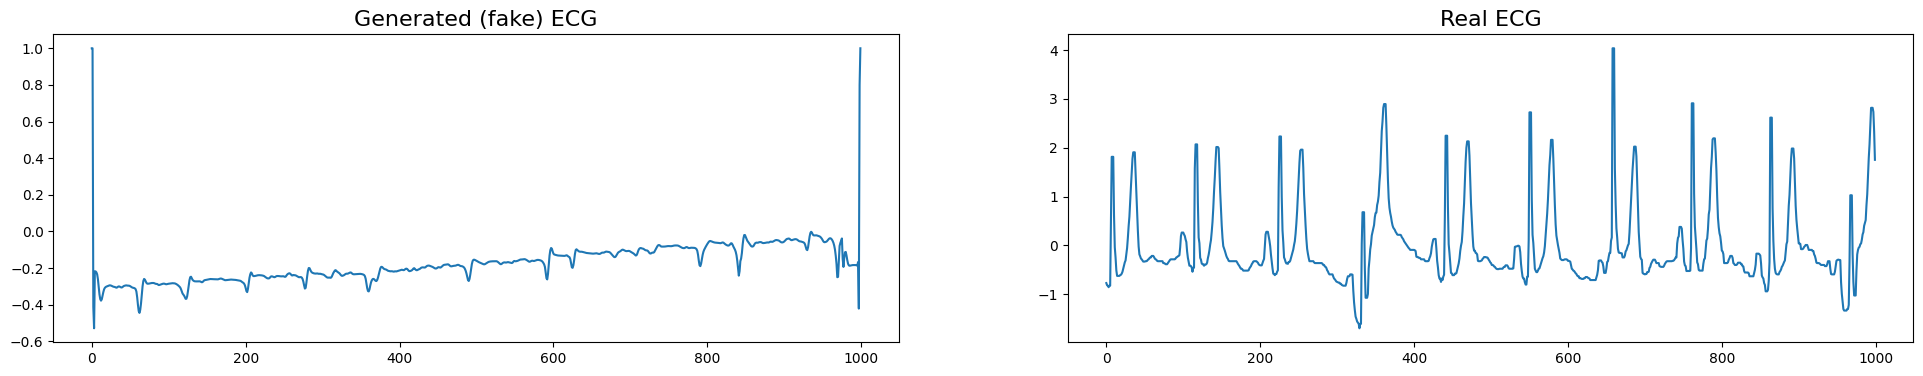

Epoch 11/2000
Generator loss: 2.1875686645507812
Discriminator loss: 5718.7529296875
-------------------
Epoch 12/2000
Generator loss: 2.445434808731079
Discriminator loss: 19690.021484375
-------------------
Epoch 13/2000
Generator loss: 2.181253671646118
Discriminator loss: 4849.15673828125
-------------------
Epoch 14/2000
Generator loss: 2.4265053272247314
Discriminator loss: 4730.89990234375
-------------------
Epoch 15/2000
Generator loss: 2.0138590335845947
Discriminator loss: 4847.1435546875
-------------------
Epoch 16/2000
Generator loss: 2.2370502948760986
Discriminator loss: 4678.79443359375
-------------------
Epoch 17/2000
Generator loss: 1.9049996137619019
Discriminator loss: 2529.99755859375
-------------------
Epoch 18/2000
Generator loss: 2.3332345485687256
Discriminator loss: 9084.240234375
-------------------
Epoch 19/2000
Generator loss: 2.2462680339813232
Discriminator loss: 5269.22802734375
-------------------
Epoch 20/2000
Generator loss: 2.1933178901672363
Disc

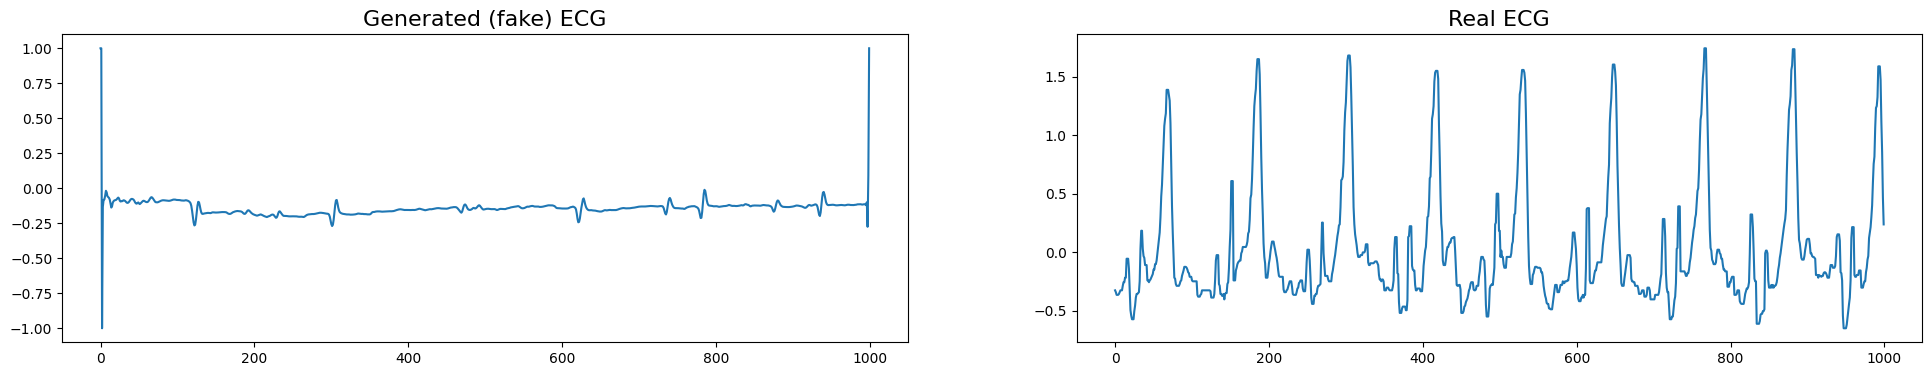

Epoch 21/2000
Generator loss: 2.165262222290039
Discriminator loss: 3521.476318359375
-------------------
Epoch 22/2000
Generator loss: 1.9178102016448975
Discriminator loss: 3525.576904296875
-------------------
Epoch 23/2000
Generator loss: 2.2124180793762207
Discriminator loss: 2933.4921875
-------------------
Epoch 24/2000
Generator loss: 2.2735540866851807
Discriminator loss: 1718.349365234375
-------------------
Epoch 25/2000
Generator loss: 2.289381265640259
Discriminator loss: 3445.96630859375
-------------------
Epoch 26/2000
Generator loss: 2.172790050506592
Discriminator loss: 3112.277587890625
-------------------
Epoch 27/2000
Generator loss: 2.353435516357422
Discriminator loss: 5111.3779296875
-------------------
Epoch 28/2000
Generator loss: 2.074660539627075
Discriminator loss: 4099.2509765625
-------------------
Epoch 29/2000
Generator loss: 2.1302366256713867
Discriminator loss: 2347.149169921875
-------------------
Epoch 30/2000
Generator loss: 2.240431785583496
Disc

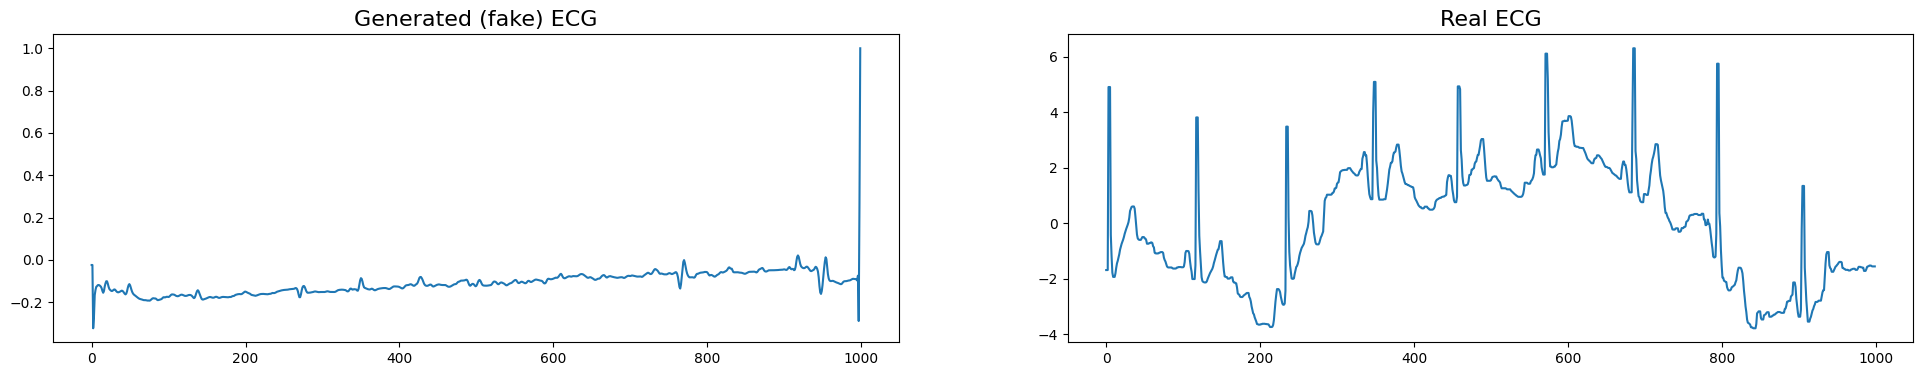

Epoch 31/2000
Generator loss: 2.1909027099609375
Discriminator loss: 2534.636474609375
-------------------
Epoch 32/2000
Generator loss: 2.018955945968628
Discriminator loss: 2945.91552734375
-------------------
Epoch 33/2000
Generator loss: 2.217860460281372
Discriminator loss: 7048.0576171875
-------------------
Epoch 34/2000
Generator loss: 2.277397394180298
Discriminator loss: 2065.964111328125
-------------------
Epoch 35/2000
Generator loss: 2.432725429534912
Discriminator loss: 7415.8076171875
-------------------
Epoch 36/2000
Generator loss: 2.179473400115967
Discriminator loss: 4428.3125
-------------------
Epoch 37/2000
Generator loss: 2.3048479557037354
Discriminator loss: 4536.71923828125
-------------------
Epoch 38/2000
Generator loss: 2.011018991470337
Discriminator loss: 5108.02490234375
-------------------
Epoch 39/2000
Generator loss: 2.159507989883423
Discriminator loss: 6148.44287109375
-------------------
Epoch 40/2000
Generator loss: 2.2460505962371826
Discriminat

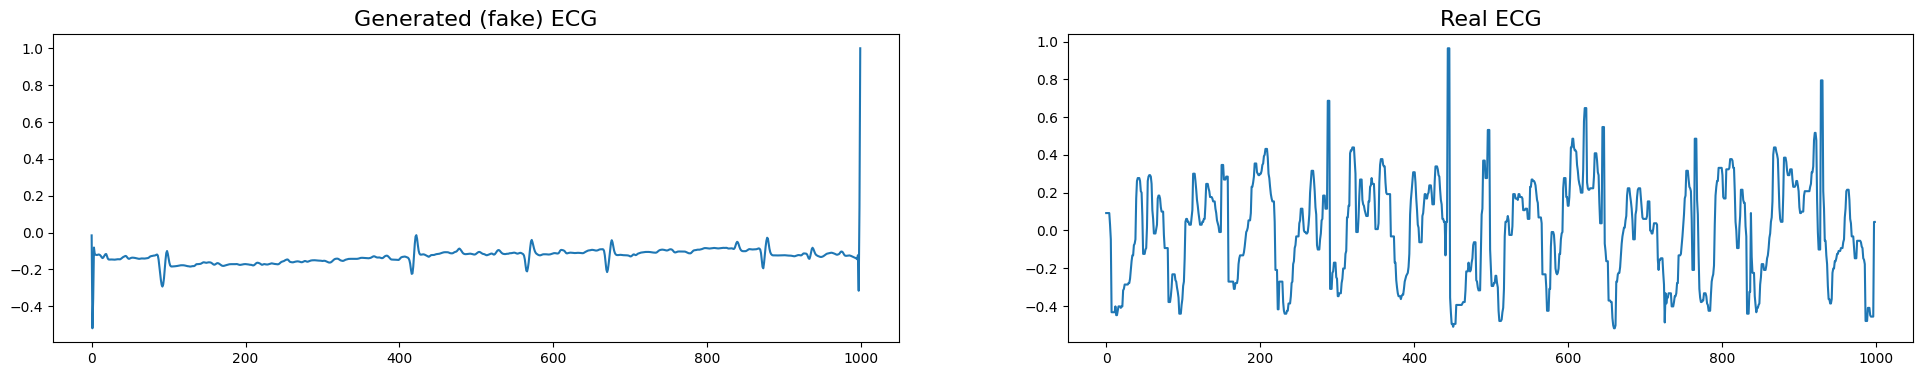

Epoch 41/2000
Generator loss: 2.431299924850464
Discriminator loss: 9359.083984375
-------------------
Epoch 42/2000
Generator loss: 2.4011075496673584
Discriminator loss: 4844.05126953125
-------------------
Epoch 43/2000
Generator loss: 2.0235092639923096
Discriminator loss: 1698.77099609375
-------------------
Epoch 44/2000
Generator loss: 2.323944568634033
Discriminator loss: 1461.927978515625
-------------------
Epoch 45/2000
Generator loss: 2.101868152618408
Discriminator loss: 2230.275390625
-------------------
Epoch 46/2000
Generator loss: 2.2549219131469727
Discriminator loss: 4348.3115234375
-------------------
Epoch 47/2000
Generator loss: 2.314014434814453
Discriminator loss: 4798.5947265625
-------------------
Epoch 48/2000
Generator loss: 2.214008092880249
Discriminator loss: 3607.630615234375
-------------------
Epoch 49/2000
Generator loss: 2.28143048286438
Discriminator loss: 4164.16455078125
-------------------
Epoch 50/2000
Generator loss: 2.339916467666626
Discrimin

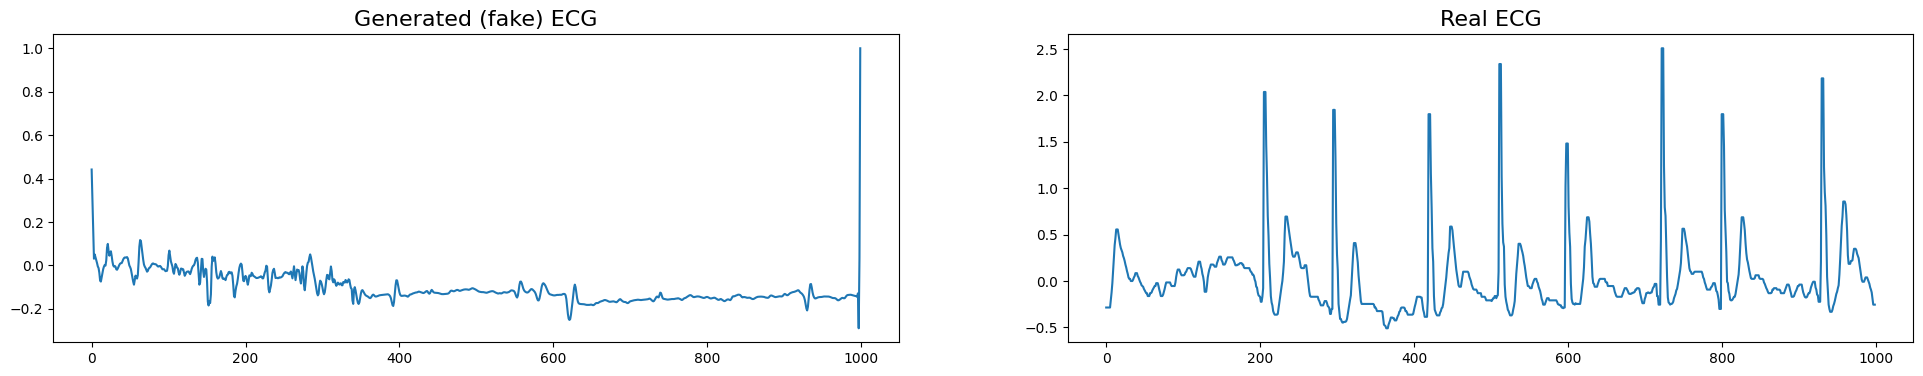

Epoch 51/2000
Generator loss: 2.0044374465942383
Discriminator loss: 1685.98779296875
-------------------
Epoch 52/2000
Generator loss: 2.3343093395233154
Discriminator loss: 3565.68896484375
-------------------
Epoch 53/2000
Generator loss: 2.212892532348633
Discriminator loss: 6036.21728515625
-------------------
Epoch 54/2000
Generator loss: 2.7920968532562256
Discriminator loss: 11748.8310546875
-------------------
Epoch 55/2000
Generator loss: 2.252478837966919
Discriminator loss: 4628.587890625
-------------------
Epoch 56/2000
Generator loss: 2.1705551147460938
Discriminator loss: 3593.557861328125
-------------------
Epoch 57/2000
Generator loss: 2.2163357734680176
Discriminator loss: 4158.90478515625
-------------------
Epoch 58/2000
Generator loss: 2.1462759971618652
Discriminator loss: 3576.944091796875
-------------------
Epoch 59/2000
Generator loss: 2.0977606773376465
Discriminator loss: 1545.2734375
-------------------
Epoch 60/2000
Generator loss: 1.944135308265686
Disc

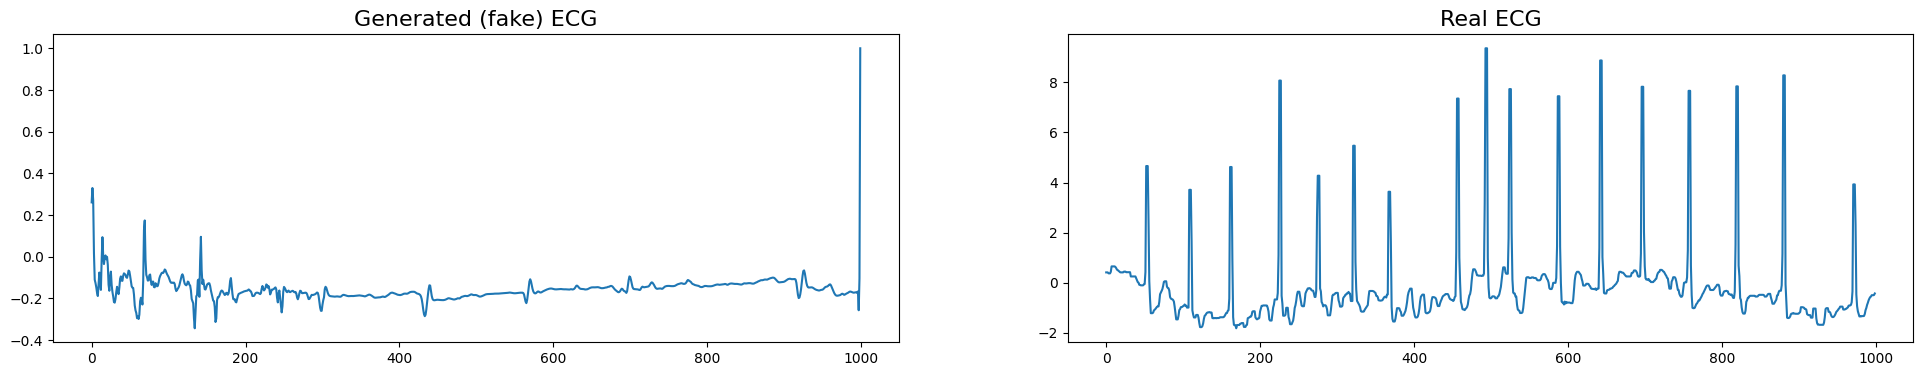

Epoch 61/2000
Generator loss: 2.11515212059021
Discriminator loss: 3406.598388671875
-------------------
Epoch 62/2000
Generator loss: 2.088696002960205
Discriminator loss: 3825.759765625
-------------------
Epoch 63/2000
Generator loss: 2.4706945419311523
Discriminator loss: 4642.14599609375
-------------------
Epoch 64/2000
Generator loss: 2.196472644805908
Discriminator loss: 2477.639404296875
-------------------
Epoch 65/2000
Generator loss: 2.162233352661133
Discriminator loss: 2136.42724609375
-------------------
Epoch 66/2000
Generator loss: 2.3582749366760254
Discriminator loss: 5463.64501953125
-------------------
Epoch 67/2000
Generator loss: 2.4969069957733154
Discriminator loss: 6331.94189453125
-------------------
Epoch 68/2000
Generator loss: 2.2098135948181152
Discriminator loss: 3804.828369140625
-------------------
Epoch 69/2000
Generator loss: 2.35803484916687
Discriminator loss: 4614.82763671875
-------------------
Epoch 70/2000
Generator loss: 2.564547538757324
Disc

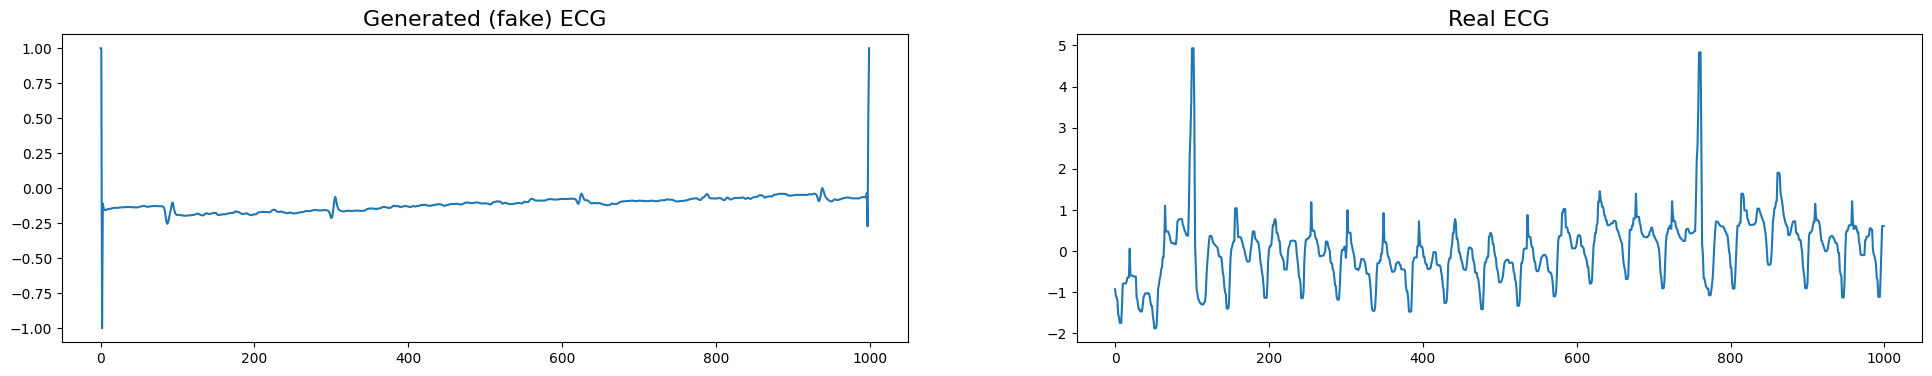

Epoch 71/2000
Generator loss: 2.458303451538086
Discriminator loss: 2577.4638671875
-------------------
Epoch 72/2000
Generator loss: 2.2064216136932373
Discriminator loss: 4803.7705078125
-------------------
Epoch 73/2000
Generator loss: 2.438673973083496
Discriminator loss: 2329.243896484375
-------------------
Epoch 74/2000
Generator loss: 2.175466299057007
Discriminator loss: 2531.745361328125
-------------------
Epoch 75/2000
Generator loss: 2.5739243030548096
Discriminator loss: 4740.22119140625
-------------------
Epoch 76/2000
Generator loss: 2.244551658630371
Discriminator loss: 1939.247314453125
-------------------
Epoch 77/2000
Generator loss: 2.156545877456665
Discriminator loss: 3639.39453125
-------------------
Epoch 78/2000
Generator loss: 2.1578872203826904
Discriminator loss: 6211.62255859375
-------------------
Epoch 79/2000
Generator loss: 2.312798500061035
Discriminator loss: 4544.1259765625
-------------------
Epoch 80/2000
Generator loss: 2.095867156982422
Discrim

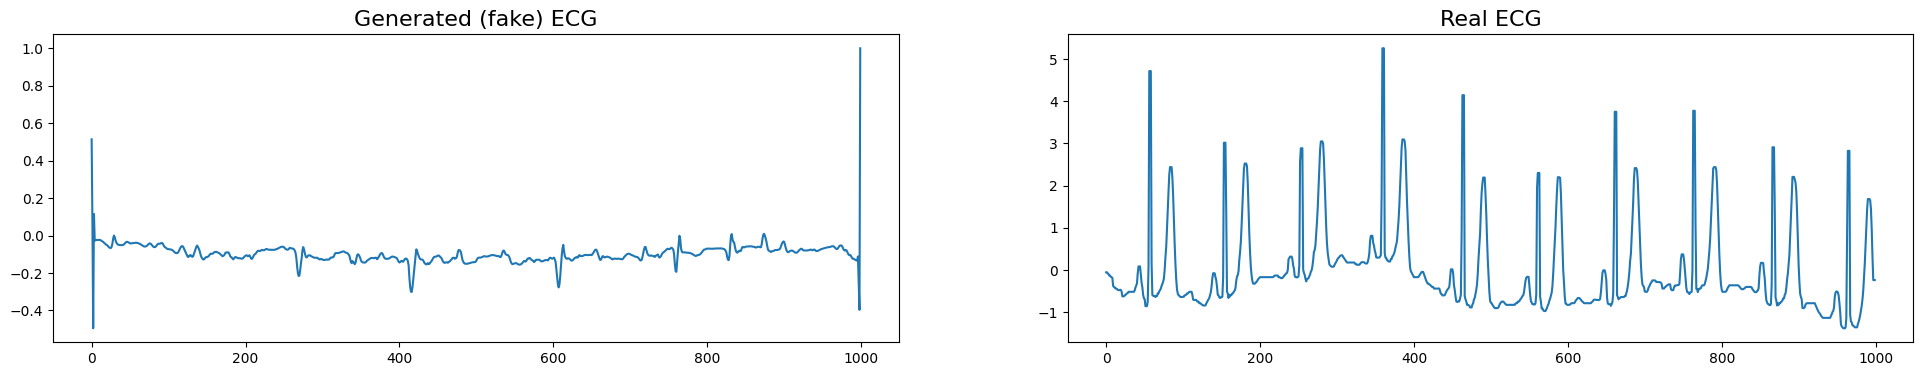

Epoch 81/2000
Generator loss: 2.102726936340332
Discriminator loss: 3536.55224609375
-------------------
Epoch 82/2000
Generator loss: 2.1716036796569824
Discriminator loss: 3925.35888671875
-------------------
Epoch 83/2000
Generator loss: 2.344109058380127
Discriminator loss: 5111.61865234375
-------------------
Epoch 84/2000
Generator loss: 2.2039103507995605
Discriminator loss: 5960.54150390625
-------------------
Epoch 85/2000
Generator loss: 2.4262585639953613
Discriminator loss: 6260.267578125
-------------------
Epoch 86/2000
Generator loss: 2.464179039001465
Discriminator loss: 6637.22021484375
-------------------
Epoch 87/2000
Generator loss: 2.293410301208496
Discriminator loss: 3662.0107421875
-------------------
Epoch 88/2000
Generator loss: 2.36163592338562
Discriminator loss: 2168.543701171875
-------------------
Epoch 89/2000
Generator loss: 2.209207773208618
Discriminator loss: 4433.49755859375
-------------------
Epoch 90/2000
Generator loss: 2.2840893268585205
Discri

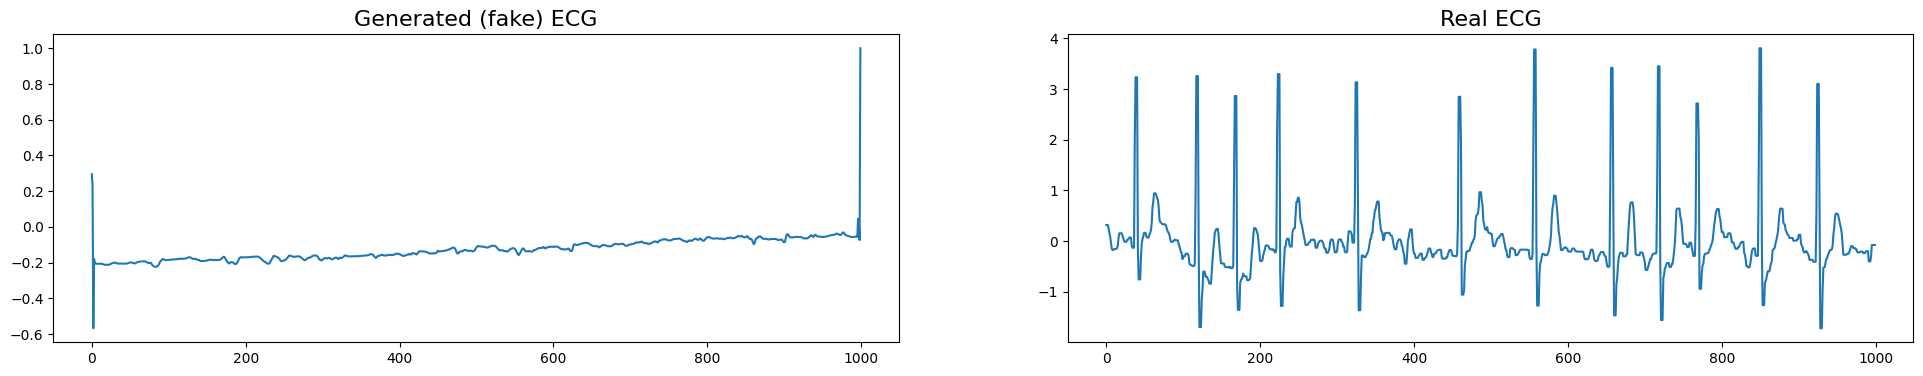

Epoch 91/2000
Generator loss: 2.4692299365997314
Discriminator loss: 5016.15185546875
-------------------
Epoch 92/2000
Generator loss: 2.4202823638916016
Discriminator loss: 3244.70361328125
-------------------
Epoch 93/2000
Generator loss: 2.398952007293701
Discriminator loss: 2236.59033203125
-------------------
Epoch 94/2000
Generator loss: 2.00407075881958
Discriminator loss: 1879.857177734375
-------------------
Epoch 95/2000
Generator loss: 2.2253808975219727
Discriminator loss: 4486.00634765625
-------------------
Epoch 96/2000
Generator loss: 2.2590465545654297
Discriminator loss: 4263.9765625
-------------------
Epoch 97/2000
Generator loss: 2.213003635406494
Discriminator loss: 3151.767822265625
-------------------
Epoch 98/2000
Generator loss: 2.2454569339752197
Discriminator loss: 3626.408447265625
-------------------
Epoch 99/2000
Generator loss: 2.2496018409729004
Discriminator loss: 1933.7119140625
-------------------
Epoch 100/2000
Generator loss: 2.468980312347412
Dis

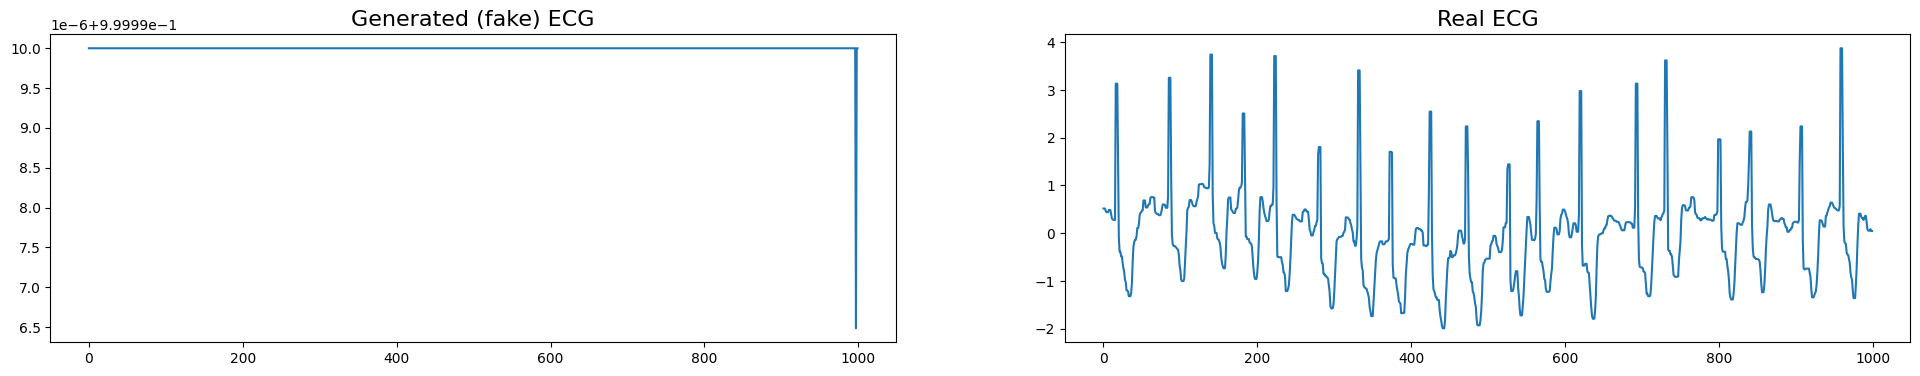

Epoch 101/2000
Generator loss: 2.0562124252319336
Discriminator loss: 3158.12548828125
-------------------
Epoch 102/2000
Generator loss: 2.324089765548706
Discriminator loss: 4087.255859375
-------------------
Epoch 103/2000
Generator loss: 2.0900232791900635
Discriminator loss: 3986.0810546875
-------------------
Epoch 104/2000
Generator loss: 2.3249871730804443
Discriminator loss: 4207.048828125
-------------------
Epoch 105/2000
Generator loss: 2.3934683799743652
Discriminator loss: 4907.99072265625
-------------------
Epoch 106/2000
Generator loss: 2.2811641693115234
Discriminator loss: 3049.268310546875
-------------------
Epoch 107/2000
Generator loss: 2.2337465286254883
Discriminator loss: 4621.65234375
-------------------
Epoch 108/2000
Generator loss: 2.0510756969451904
Discriminator loss: 2388.9833984375
-------------------
Epoch 109/2000
Generator loss: 2.1941099166870117
Discriminator loss: 14493.4599609375
-------------------
Epoch 110/2000
Generator loss: 2.0735888481140

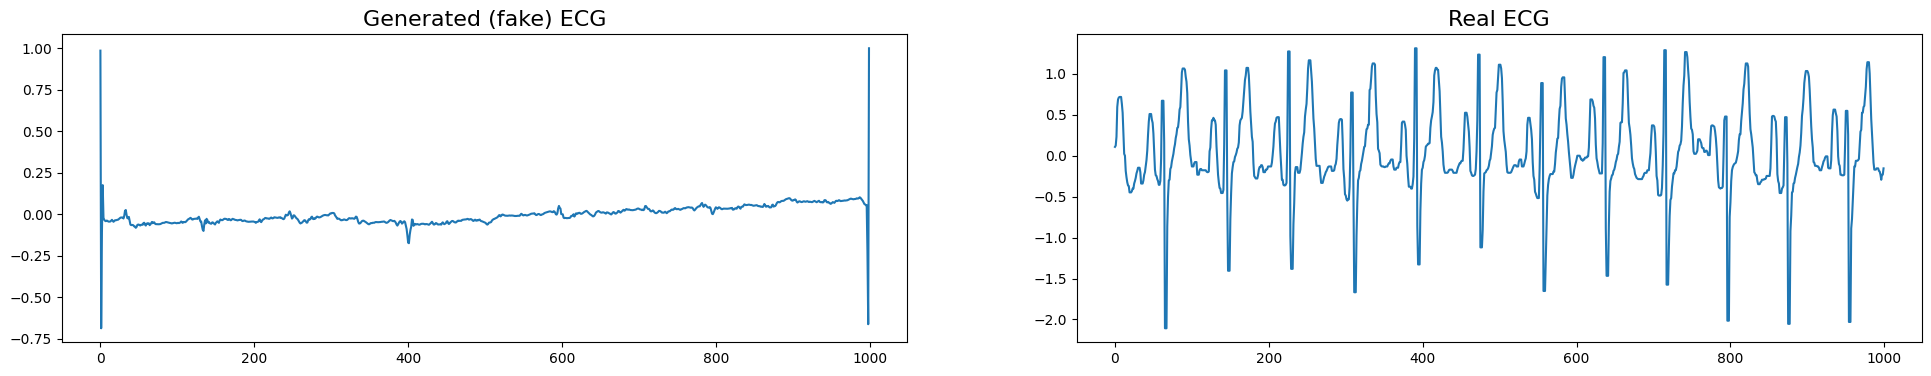

Epoch 111/2000
Generator loss: 2.07433819770813
Discriminator loss: 4297.16015625
-------------------
Epoch 112/2000
Generator loss: 2.276036024093628
Discriminator loss: 4376.10888671875
-------------------
Epoch 113/2000
Generator loss: 2.171621561050415
Discriminator loss: 4221.041015625
-------------------
Epoch 114/2000
Generator loss: 2.4437217712402344
Discriminator loss: 6396.89111328125
-------------------
Epoch 115/2000
Generator loss: 2.0262045860290527
Discriminator loss: 2737.5078125
-------------------
Epoch 116/2000
Generator loss: 2.311113119125366
Discriminator loss: 6241.12646484375
-------------------
Epoch 117/2000
Generator loss: 2.6276237964630127
Discriminator loss: 10290.1845703125
-------------------
Epoch 118/2000
Generator loss: 2.455794334411621
Discriminator loss: 5901.47705078125
-------------------
Epoch 119/2000
Generator loss: 2.1578662395477295
Discriminator loss: 4040.8984375
-------------------
Epoch 120/2000
Generator loss: 2.2532711029052734
Discri

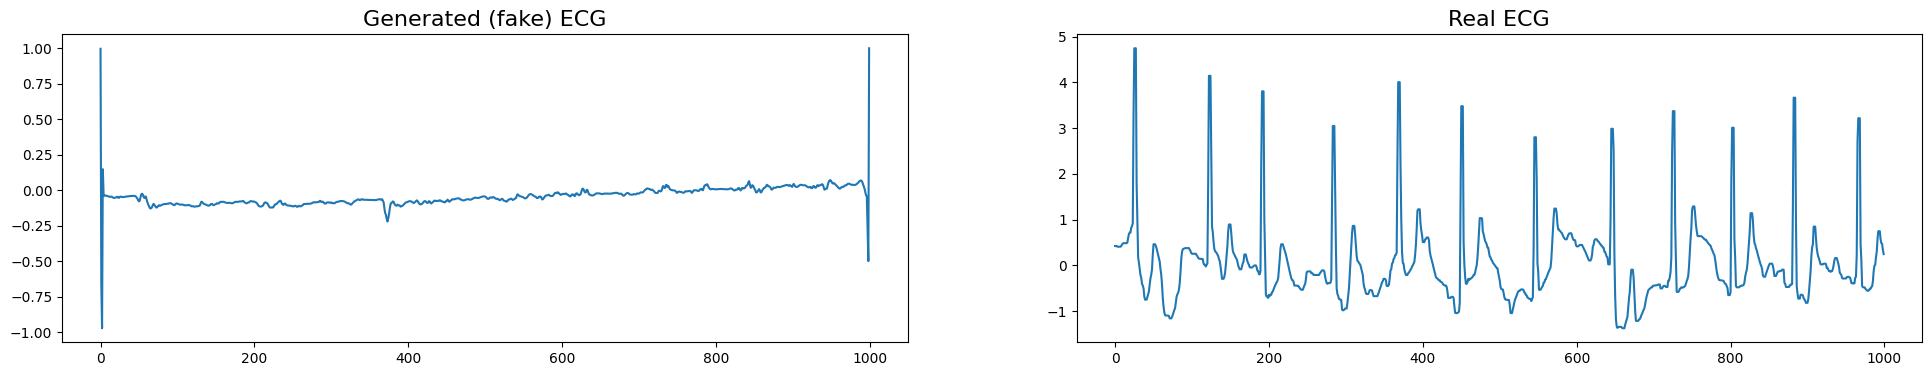

Epoch 121/2000
Generator loss: 2.199519157409668
Discriminator loss: 53776.1015625
-------------------
Epoch 122/2000
Generator loss: 2.2069573402404785
Discriminator loss: 2580.46923828125
-------------------
Epoch 123/2000
Generator loss: 2.815812587738037
Discriminator loss: 8003.9521484375
-------------------
Epoch 124/2000
Generator loss: 2.0256576538085938
Discriminator loss: 3073.07958984375
-------------------
Epoch 125/2000
Generator loss: 2.2684097290039062
Discriminator loss: 6006.24267578125
-------------------
Epoch 126/2000
Generator loss: 2.0740480422973633
Discriminator loss: 2025.7955322265625
-------------------
Epoch 127/2000
Generator loss: 2.0937631130218506
Discriminator loss: 3690.581298828125
-------------------
Epoch 128/2000
Generator loss: 2.2549123764038086
Discriminator loss: 9178.3779296875
-------------------
Epoch 129/2000
Generator loss: 2.122859477996826
Discriminator loss: 2605.9443359375
-------------------
Epoch 130/2000
Generator loss: 2.0737485885

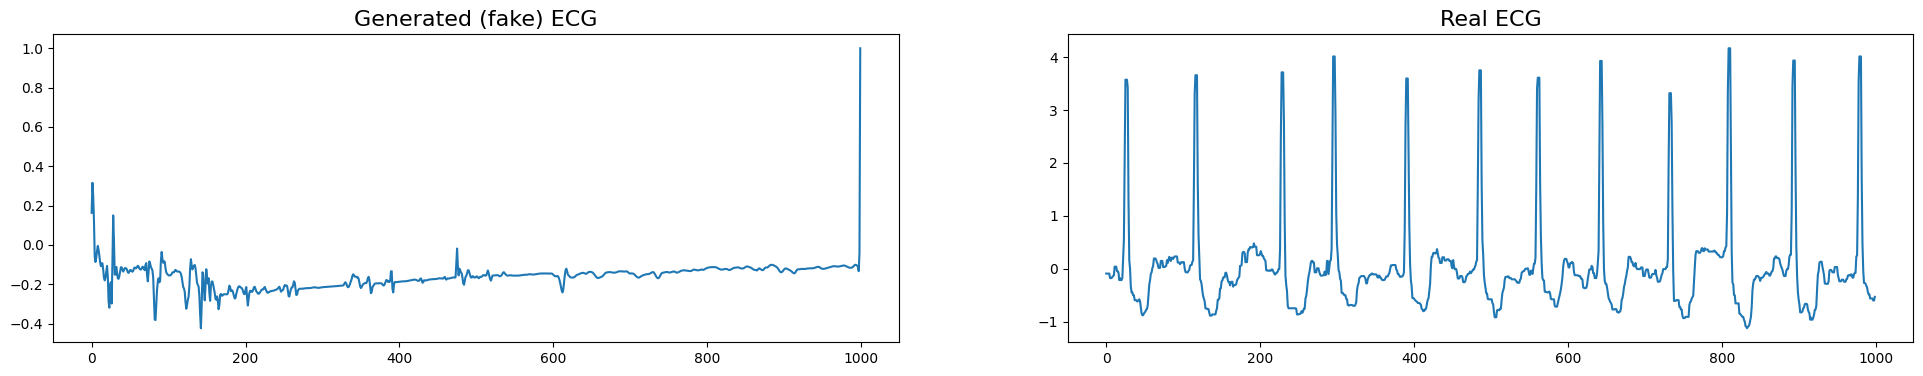

Epoch 131/2000
Generator loss: 2.3228540420532227
Discriminator loss: 3827.93798828125
-------------------
Epoch 132/2000
Generator loss: 2.1433889865875244
Discriminator loss: 4909.68310546875
-------------------
Epoch 133/2000
Generator loss: 2.1187615394592285
Discriminator loss: 5893.69677734375
-------------------
Epoch 134/2000
Generator loss: 2.330933094024658
Discriminator loss: 11212.75390625
-------------------
Epoch 135/2000
Generator loss: 2.2376739978790283
Discriminator loss: 4643.5966796875
-------------------
Epoch 136/2000
Generator loss: 2.258150577545166
Discriminator loss: 3909.355712890625
-------------------
Epoch 137/2000
Generator loss: 2.2391517162323
Discriminator loss: 4684.181640625
-------------------
Epoch 138/2000
Generator loss: 2.7123100757598877
Discriminator loss: 3627.765625
-------------------
Epoch 139/2000
Generator loss: 2.8317158222198486
Discriminator loss: 11455.2880859375
-------------------
Epoch 140/2000
Generator loss: 2.170889377593994
Di

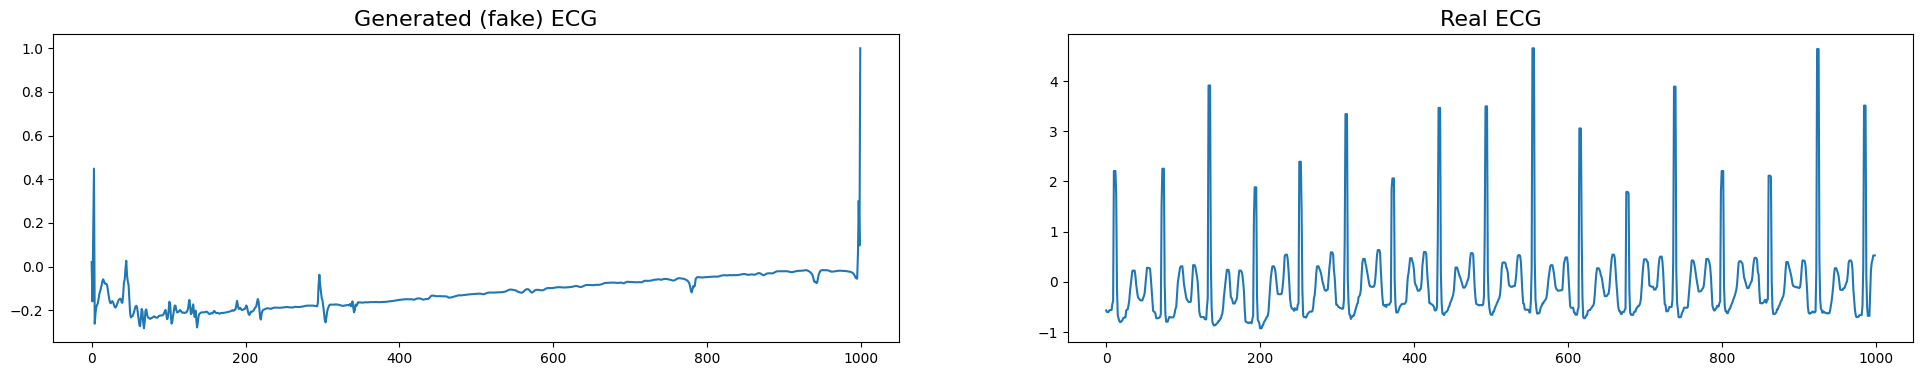

Epoch 141/2000
Generator loss: 2.2043373584747314
Discriminator loss: 3115.67333984375
-------------------
Epoch 142/2000
Generator loss: 2.134942054748535
Discriminator loss: 2765.896240234375
-------------------
Epoch 143/2000
Generator loss: 2.173733711242676
Discriminator loss: 1710.7039794921875
-------------------
Epoch 144/2000
Generator loss: 2.3016233444213867
Discriminator loss: 4395.0205078125
-------------------
Epoch 145/2000
Generator loss: 2.3298349380493164
Discriminator loss: 1559.1259765625
-------------------
Epoch 146/2000
Generator loss: 2.1971709728240967
Discriminator loss: 5772.890625
-------------------
Epoch 147/2000
Generator loss: 2.1996774673461914
Discriminator loss: 1942.40380859375
-------------------
Epoch 148/2000
Generator loss: 2.176980495452881
Discriminator loss: 4260.46142578125
-------------------
Epoch 149/2000
Generator loss: 2.562779188156128
Discriminator loss: 3932.97802734375
-------------------
Epoch 150/2000
Generator loss: 2.280235528945

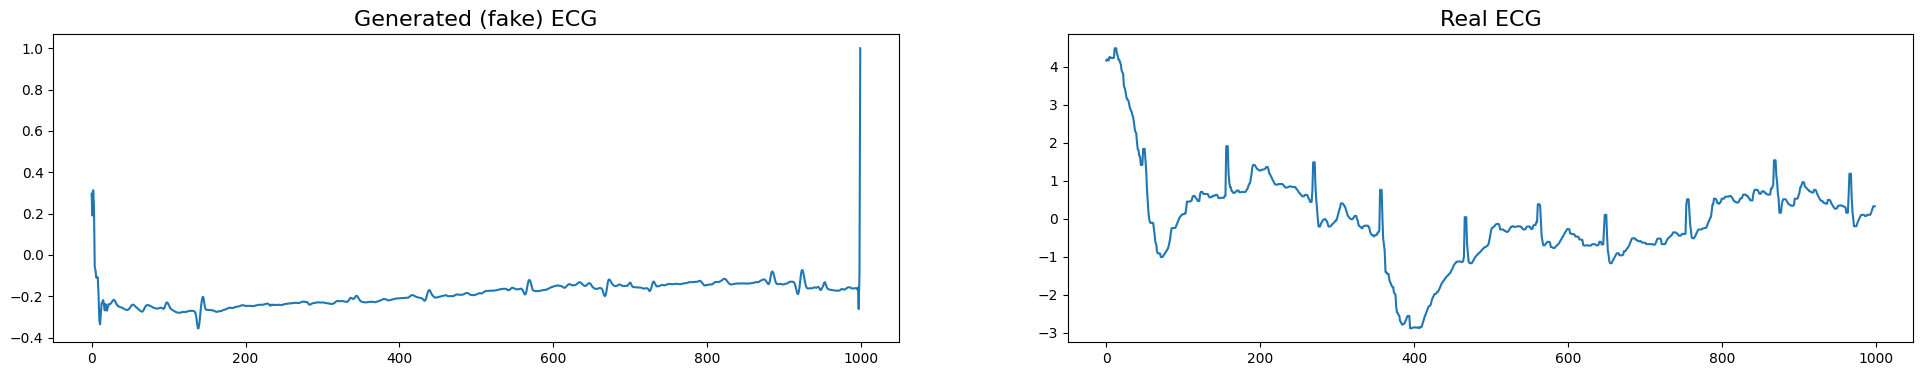

Epoch 151/2000
Generator loss: 2.3545961380004883
Discriminator loss: 3532.420654296875
-------------------
Epoch 152/2000
Generator loss: 2.120060682296753
Discriminator loss: 2255.423095703125
-------------------
Epoch 153/2000
Generator loss: 2.35046124458313
Discriminator loss: 3394.113037109375
-------------------
Epoch 154/2000
Generator loss: 2.1786234378814697
Discriminator loss: 2375.9541015625
-------------------
Epoch 155/2000
Generator loss: 2.034348964691162
Discriminator loss: 1807.64892578125
-------------------
Epoch 156/2000
Generator loss: 3.06840443611145
Discriminator loss: 26091.1484375
-------------------
Epoch 157/2000
Generator loss: 2.1644701957702637
Discriminator loss: 7306.1787109375
-------------------
Epoch 158/2000
Generator loss: 2.1441922187805176
Discriminator loss: 2893.829833984375
-------------------
Epoch 159/2000
Generator loss: 2.267982244491577
Discriminator loss: 5239.1279296875
-------------------
Epoch 160/2000
Generator loss: 2.1970987319946

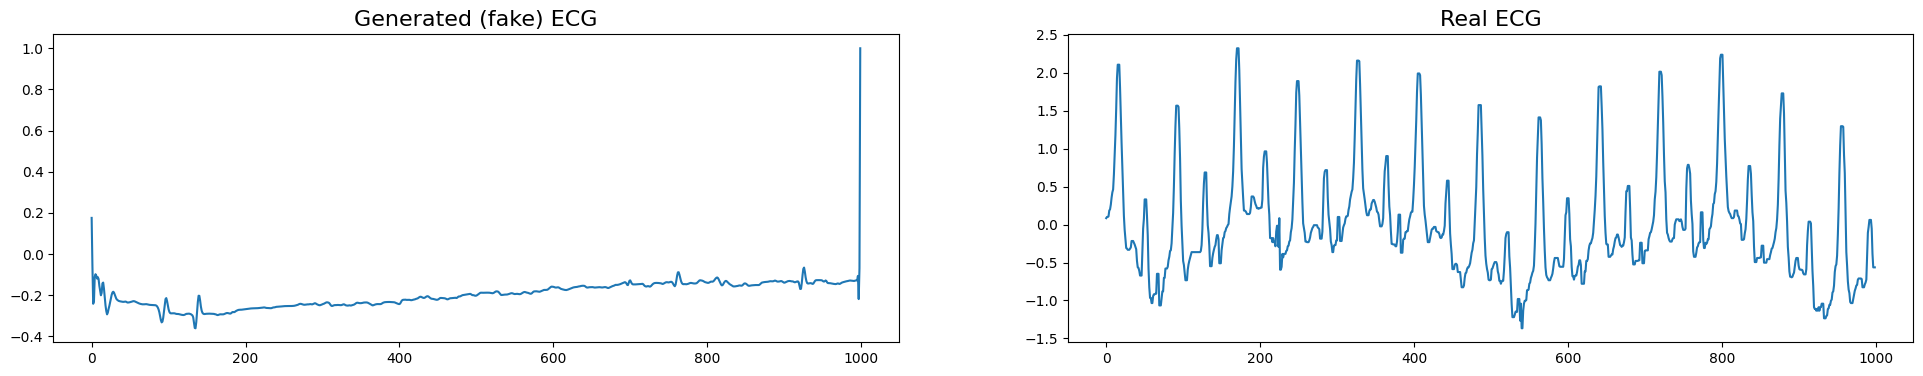

Epoch 161/2000
Generator loss: 2.1993002891540527
Discriminator loss: 3415.2001953125
-------------------
Epoch 162/2000
Generator loss: 2.342991352081299
Discriminator loss: 9839.6884765625
-------------------
Epoch 163/2000
Generator loss: 2.145740032196045
Discriminator loss: 2542.52099609375
-------------------
Epoch 164/2000
Generator loss: 2.3622546195983887
Discriminator loss: 7005.53515625
-------------------
Epoch 165/2000
Generator loss: 2.3241233825683594
Discriminator loss: 2105.20751953125
-------------------
Epoch 166/2000
Generator loss: 2.1387779712677
Discriminator loss: 2452.64599609375
-------------------
Epoch 167/2000
Generator loss: 2.3523552417755127
Discriminator loss: 3167.0166015625
-------------------
Epoch 168/2000
Generator loss: 2.344083309173584
Discriminator loss: 4691.85302734375
-------------------
Epoch 169/2000
Generator loss: 2.143728256225586
Discriminator loss: 3285.93994140625
-------------------
Epoch 170/2000
Generator loss: 2.363680839538574
D

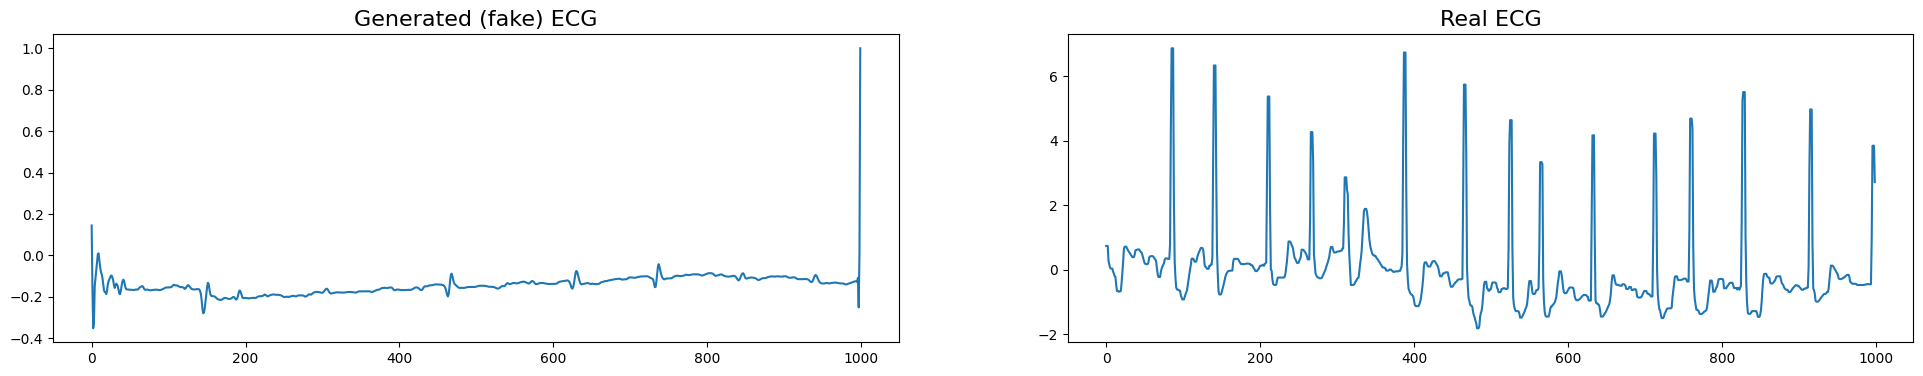

Epoch 171/2000
Generator loss: 2.2925970554351807
Discriminator loss: 4158.96923828125
-------------------
Epoch 172/2000
Generator loss: 2.255141019821167
Discriminator loss: 3764.607177734375
-------------------
Epoch 173/2000
Generator loss: 2.0904481410980225
Discriminator loss: 5402.4970703125
-------------------
Epoch 174/2000
Generator loss: 2.3072566986083984
Discriminator loss: 4219.00830078125
-------------------
Epoch 175/2000
Generator loss: 2.4049794673919678
Discriminator loss: 12052.8271484375
-------------------
Epoch 176/2000
Generator loss: 2.142195463180542
Discriminator loss: 6652.28662109375
-------------------
Epoch 177/2000
Generator loss: 2.2570736408233643
Discriminator loss: 5702.88232421875
-------------------
Epoch 178/2000
Generator loss: 2.114952564239502
Discriminator loss: 2076.066162109375
-------------------
Epoch 179/2000
Generator loss: 2.7625646591186523
Discriminator loss: 8633.6298828125
-------------------
Epoch 180/2000
Generator loss: 2.1114163

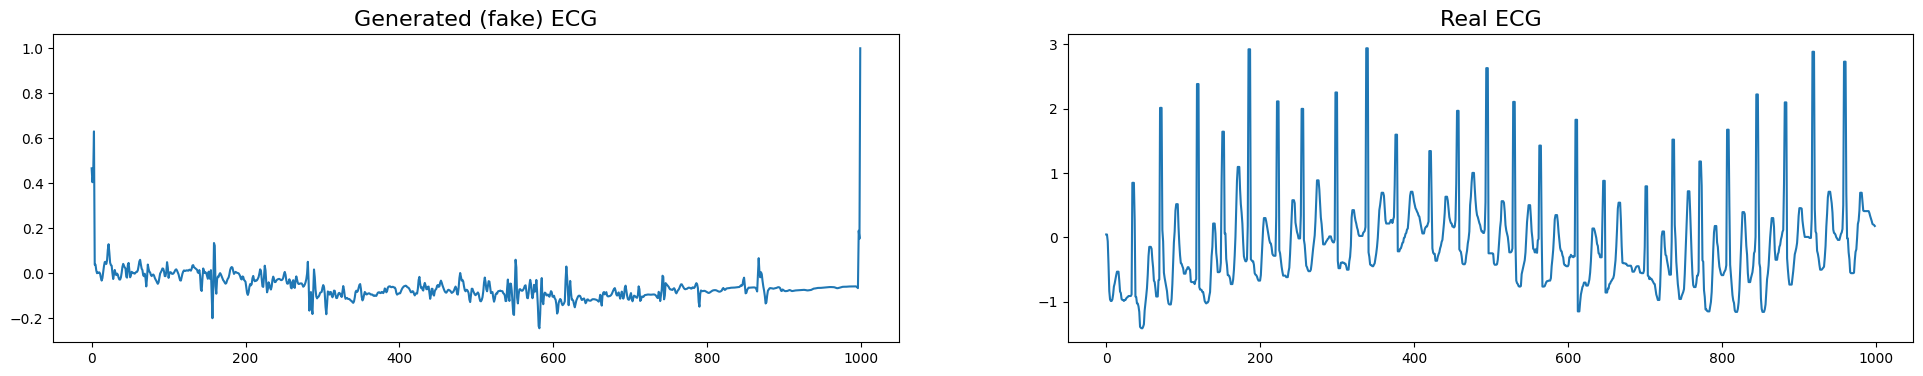

Epoch 181/2000
Generator loss: 2.487663507461548
Discriminator loss: 7603.73388671875
-------------------
Epoch 182/2000
Generator loss: 2.234876871109009
Discriminator loss: 3125.7373046875
-------------------
Epoch 183/2000
Generator loss: 2.0539710521698
Discriminator loss: 1341.35986328125
-------------------
Epoch 184/2000
Generator loss: 2.302245616912842
Discriminator loss: 5637.16943359375
-------------------
Epoch 185/2000
Generator loss: 2.0517737865448
Discriminator loss: 1534.4820556640625
-------------------
Epoch 186/2000
Generator loss: 2.0692451000213623
Discriminator loss: 2504.18310546875
-------------------
Epoch 187/2000
Generator loss: 2.3266983032226562
Discriminator loss: 1599.2283935546875
-------------------
Epoch 188/2000
Generator loss: 2.257324695587158
Discriminator loss: 2679.35009765625
-------------------
Epoch 189/2000
Generator loss: 2.3640527725219727
Discriminator loss: 3870.822021484375
-------------------
Epoch 190/2000
Generator loss: 2.0813837051

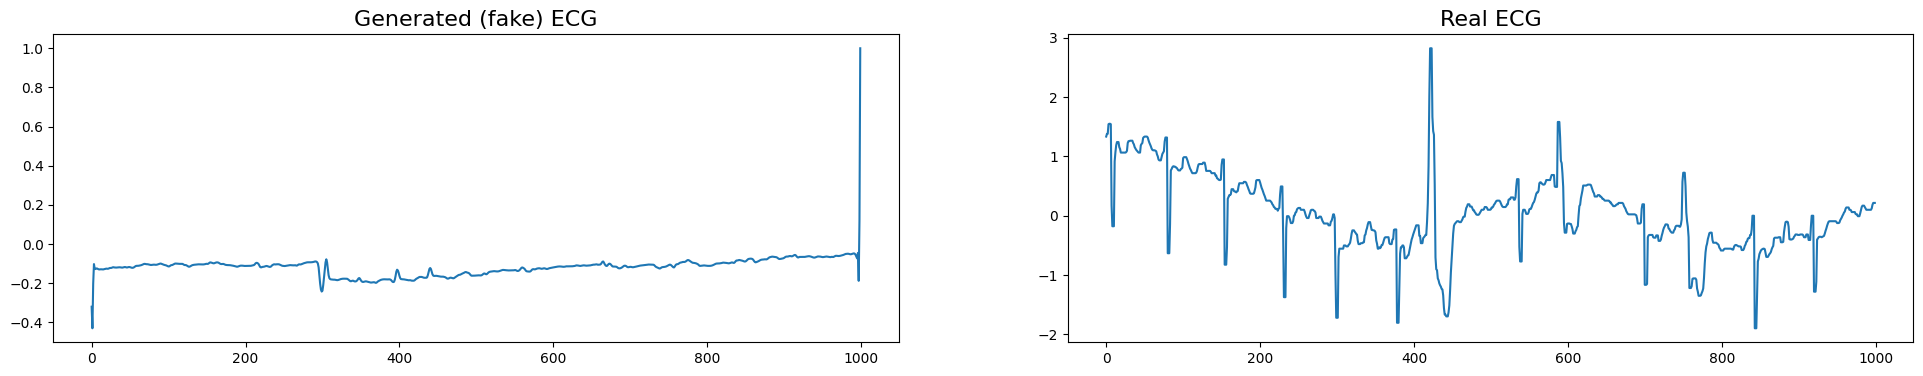

Epoch 191/2000
Generator loss: 2.1876397132873535
Discriminator loss: 3592.8232421875
-------------------
Epoch 192/2000
Generator loss: 2.0583319664001465
Discriminator loss: 4488.21533203125
-------------------
Epoch 193/2000
Generator loss: 2.4243974685668945
Discriminator loss: 5436.75
-------------------
Epoch 194/2000
Generator loss: 1.9847080707550049
Discriminator loss: 1556.4849853515625
-------------------
Epoch 195/2000
Generator loss: 2.2503631114959717
Discriminator loss: 5546.52294921875
-------------------
Epoch 196/2000
Generator loss: 2.2630488872528076
Discriminator loss: 4416.29833984375
-------------------
Epoch 197/2000
Generator loss: 2.409176826477051
Discriminator loss: 3682.609130859375
-------------------
Epoch 198/2000
Generator loss: 2.285193681716919
Discriminator loss: 6208.8271484375
-------------------
Epoch 199/2000
Generator loss: 2.309772491455078
Discriminator loss: 4311.48681640625
-------------------
Epoch 200/2000
Generator loss: 2.529388189315796

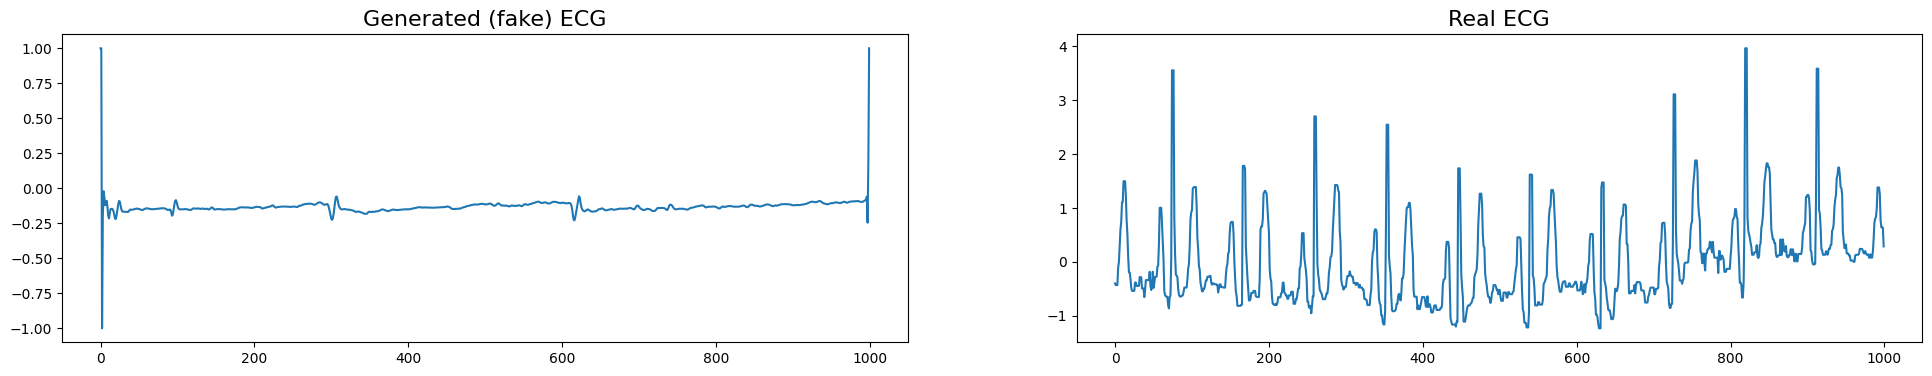

Epoch 201/2000
Generator loss: 2.276585102081299
Discriminator loss: 6036.05908203125
-------------------
Epoch 202/2000
Generator loss: 2.2403342723846436
Discriminator loss: 2730.368408203125
-------------------
Epoch 203/2000
Generator loss: 2.1202280521392822
Discriminator loss: 1925.2086181640625
-------------------
Epoch 204/2000
Generator loss: 2.3475534915924072
Discriminator loss: 5863.6123046875
-------------------
Epoch 205/2000
Generator loss: 2.5251355171203613
Discriminator loss: 5299.669921875
-------------------
Epoch 206/2000
Generator loss: 2.2045507431030273
Discriminator loss: 2103.7626953125
-------------------
Epoch 207/2000
Generator loss: 2.4539566040039062
Discriminator loss: 6888.4921875
-------------------
Epoch 208/2000
Generator loss: 2.491960287094116
Discriminator loss: 6907.763671875
-------------------
Epoch 209/2000
Generator loss: 2.122753143310547
Discriminator loss: 5392.224609375
-------------------
Epoch 210/2000
Generator loss: 2.1635570526123047

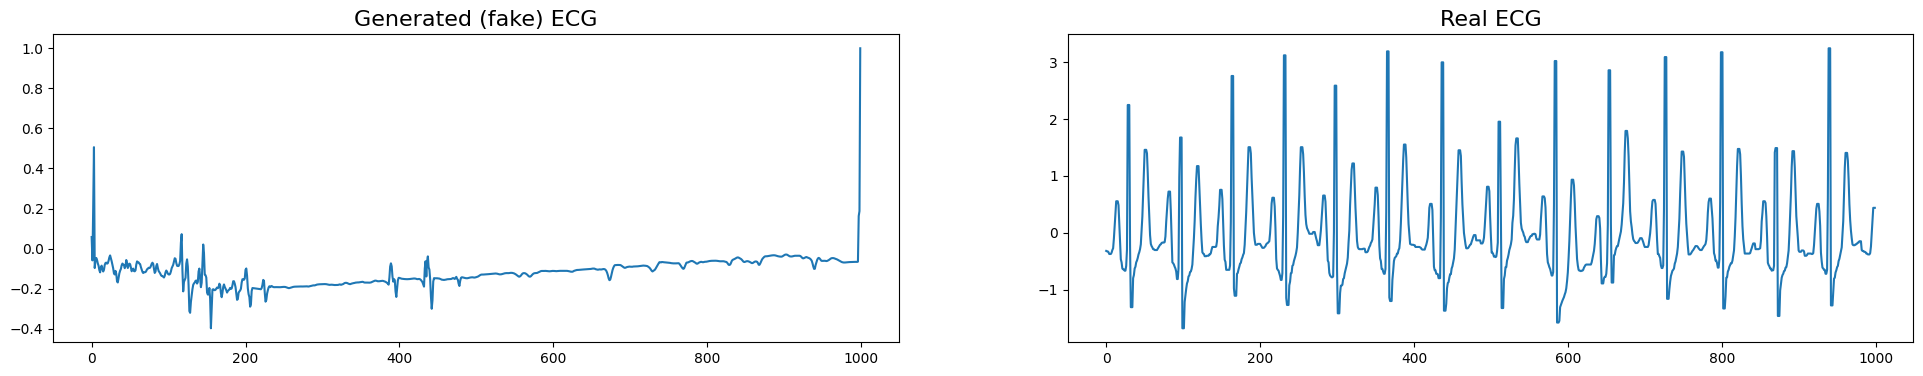

Epoch 211/2000
Generator loss: 2.1451547145843506
Discriminator loss: 4706.9130859375
-------------------
Epoch 212/2000
Generator loss: 2.257303237915039
Discriminator loss: 4138.673828125
-------------------
Epoch 213/2000
Generator loss: 2.3947269916534424
Discriminator loss: 3502.355712890625
-------------------
Epoch 214/2000
Generator loss: 2.4276514053344727
Discriminator loss: 7512.66162109375
-------------------
Epoch 215/2000
Generator loss: 2.2529261112213135
Discriminator loss: 2717.181640625
-------------------
Epoch 216/2000
Generator loss: 2.4165070056915283
Discriminator loss: 7990.025390625
-------------------
Epoch 217/2000
Generator loss: 2.2426514625549316
Discriminator loss: 2733.060546875
-------------------
Epoch 218/2000
Generator loss: 2.2756168842315674
Discriminator loss: 4213.029296875
-------------------
Epoch 219/2000
Generator loss: 2.4257712364196777
Discriminator loss: 3725.4794921875
-------------------
Epoch 220/2000
Generator loss: 2.247182607650757


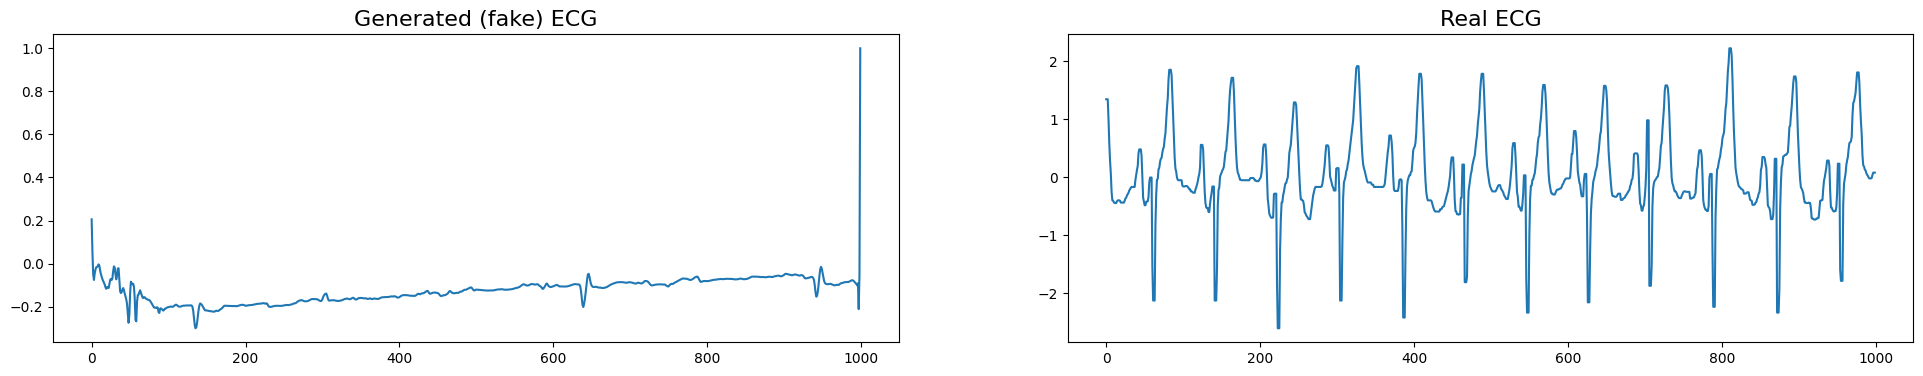

Epoch 221/2000
Generator loss: 2.1515426635742188
Discriminator loss: 4135.61376953125
-------------------
Epoch 222/2000
Generator loss: 2.2666006088256836
Discriminator loss: 2817.363037109375
-------------------
Epoch 223/2000
Generator loss: 2.119011163711548
Discriminator loss: 4721.044921875
-------------------
Epoch 224/2000
Generator loss: 2.385533332824707
Discriminator loss: 5937.6767578125
-------------------
Epoch 225/2000
Generator loss: 2.275646686553955
Discriminator loss: 7666.630859375
-------------------
Epoch 226/2000
Generator loss: 2.103273630142212
Discriminator loss: 3141.922119140625
-------------------
Epoch 227/2000
Generator loss: 2.126765012741089
Discriminator loss: 2299.64501953125
-------------------
Epoch 228/2000
Generator loss: 2.1825921535491943
Discriminator loss: 2657.694091796875
-------------------
Epoch 229/2000
Generator loss: 2.2396748065948486
Discriminator loss: 4052.94287109375
-------------------
Epoch 230/2000
Generator loss: 2.23491787910

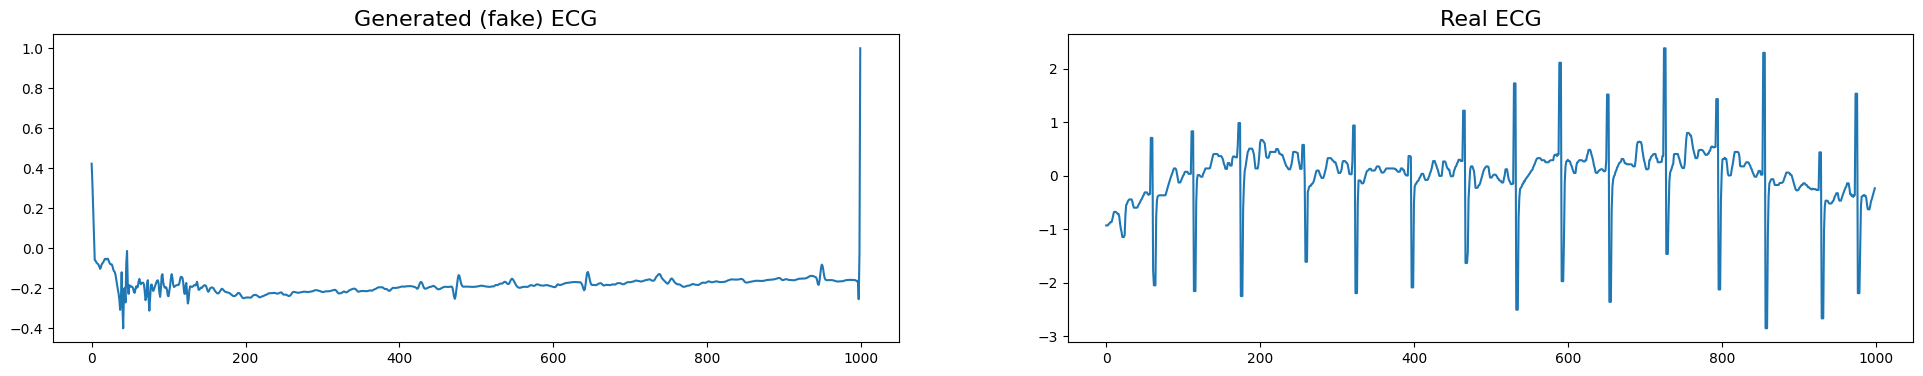

Epoch 231/2000
Generator loss: 2.1352057456970215
Discriminator loss: 4227.916015625
-------------------
Epoch 232/2000
Generator loss: 2.088548183441162
Discriminator loss: 5443.47412109375
-------------------
Epoch 233/2000
Generator loss: 2.1698036193847656
Discriminator loss: 4222.37109375
-------------------
Epoch 234/2000
Generator loss: 2.2215147018432617
Discriminator loss: 2464.3740234375
-------------------
Epoch 235/2000
Generator loss: 2.8900279998779297
Discriminator loss: 3107.41064453125
-------------------
Epoch 236/2000
Generator loss: 2.2943525314331055
Discriminator loss: 5265.97216796875
-------------------
Epoch 237/2000
Generator loss: 2.0175342559814453
Discriminator loss: 2495.122802734375
-------------------
Epoch 238/2000
Generator loss: 2.15425968170166
Discriminator loss: 4000.584228515625
-------------------
Epoch 239/2000
Generator loss: 2.111021041870117
Discriminator loss: 3988.5771484375
-------------------
Epoch 240/2000
Generator loss: 2.2422912120819

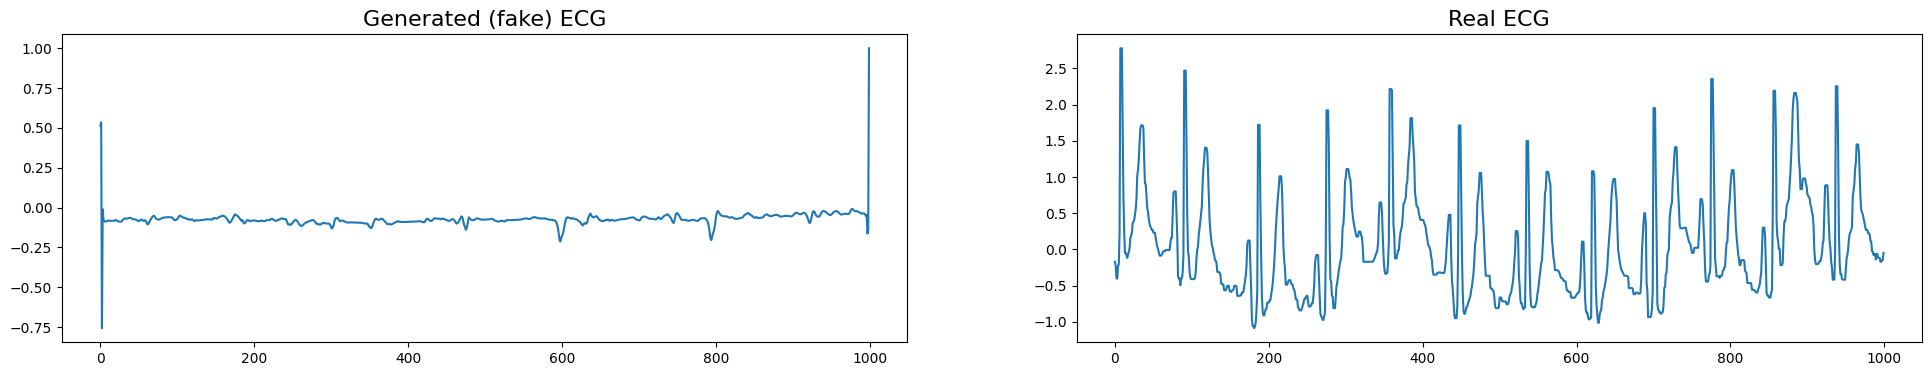

Epoch 241/2000
Generator loss: 2.1298110485076904
Discriminator loss: 3204.085205078125
-------------------
Epoch 242/2000
Generator loss: 2.4444072246551514
Discriminator loss: 3306.67822265625
-------------------
Epoch 243/2000
Generator loss: 2.1415717601776123
Discriminator loss: 2416.47265625
-------------------
Epoch 244/2000
Generator loss: 2.3413333892822266
Discriminator loss: 4340.34130859375
-------------------
Epoch 245/2000
Generator loss: 2.170968532562256
Discriminator loss: 2614.087890625
-------------------
Epoch 246/2000
Generator loss: 2.416288137435913
Discriminator loss: 3056.377685546875
-------------------
Epoch 247/2000
Generator loss: 2.0587968826293945
Discriminator loss: 3062.510009765625
-------------------
Epoch 248/2000
Generator loss: 2.2289769649505615
Discriminator loss: 4290.859375
-------------------
Epoch 249/2000
Generator loss: 2.4835002422332764
Discriminator loss: 3399.416259765625
-------------------
Epoch 250/2000
Generator loss: 2.251283168792

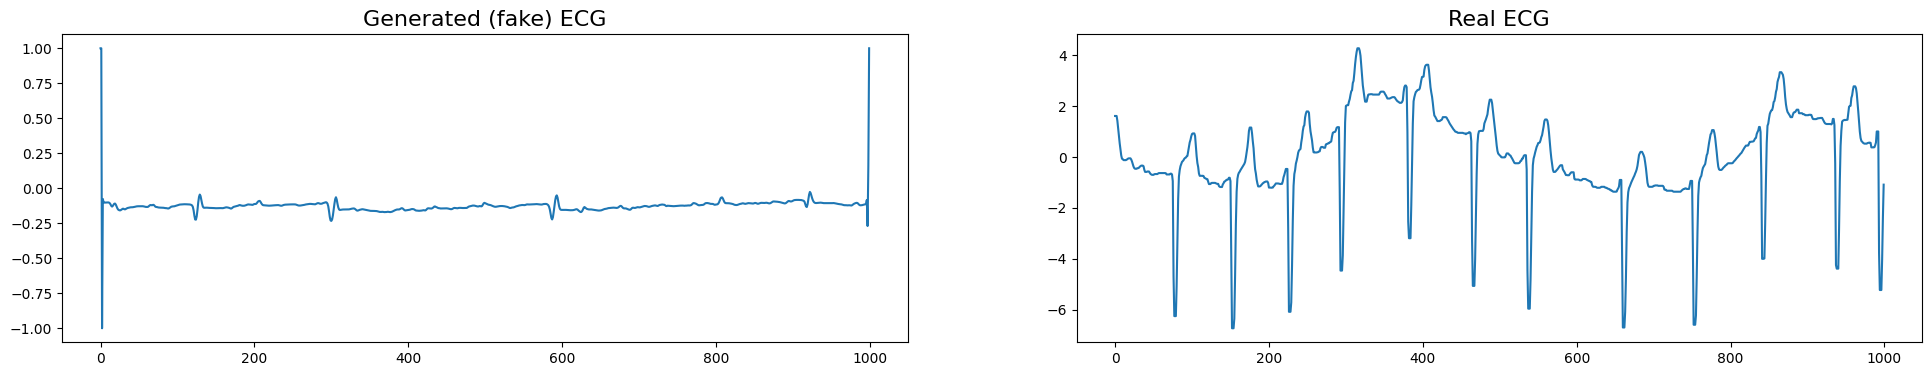

Epoch 251/2000
Generator loss: 2.398527145385742
Discriminator loss: 5594.72216796875
-------------------
Epoch 252/2000
Generator loss: 2.3508994579315186
Discriminator loss: 9019.2041015625
-------------------
Epoch 253/2000
Generator loss: 2.301391124725342
Discriminator loss: 4910.68896484375
-------------------
Epoch 254/2000
Generator loss: 2.3315067291259766
Discriminator loss: 2594.6728515625
-------------------
Epoch 255/2000
Generator loss: 2.225188970565796
Discriminator loss: 3247.017822265625
-------------------
Epoch 256/2000
Generator loss: 2.2106900215148926
Discriminator loss: 3663.998291015625
-------------------
Epoch 257/2000
Generator loss: 2.1901659965515137
Discriminator loss: 1777.7701416015625
-------------------
Epoch 258/2000
Generator loss: 2.467944860458374
Discriminator loss: 3158.960693359375
-------------------
Epoch 259/2000
Generator loss: 2.3448641300201416
Discriminator loss: 5655.24951171875
-------------------
Epoch 260/2000
Generator loss: 2.27096

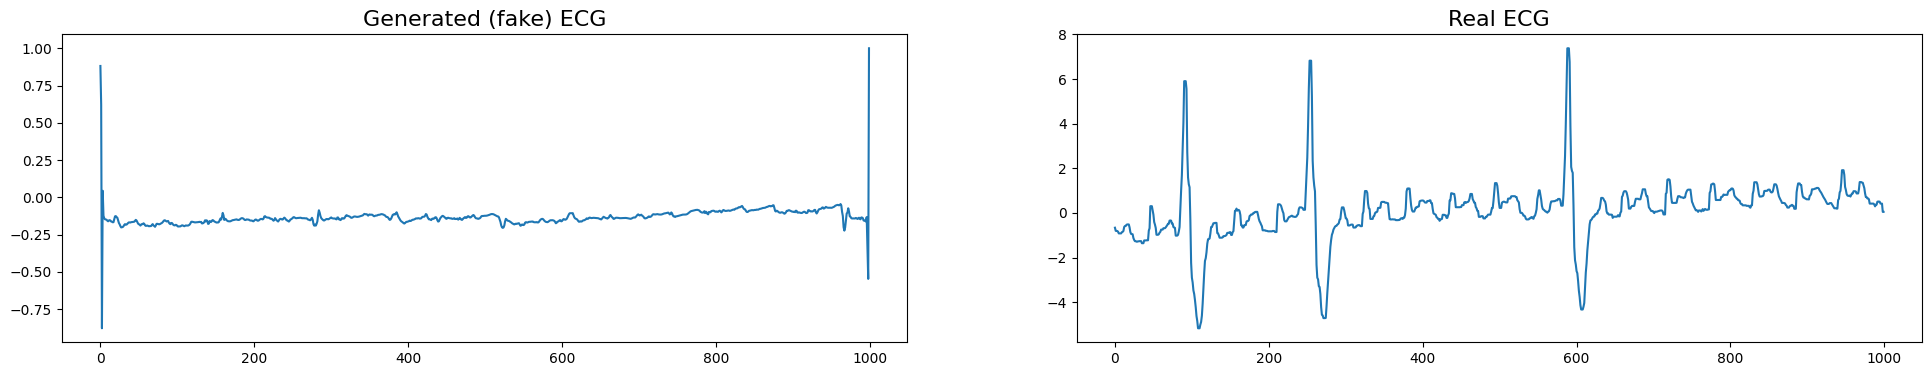

Epoch 261/2000
Generator loss: 2.0719316005706787
Discriminator loss: 4333.85888671875
-------------------
Epoch 262/2000
Generator loss: 2.301997423171997
Discriminator loss: 4867.5537109375
-------------------
Epoch 263/2000
Generator loss: 2.1496551036834717
Discriminator loss: 2675.4482421875
-------------------
Epoch 264/2000
Generator loss: 2.071005344390869
Discriminator loss: 3356.98193359375
-------------------
Epoch 265/2000
Generator loss: 2.0814599990844727
Discriminator loss: 1781.1959228515625
-------------------
Epoch 266/2000
Generator loss: 2.2953405380249023
Discriminator loss: 4084.16748046875
-------------------
Epoch 267/2000
Generator loss: 2.248425006866455
Discriminator loss: 3479.16064453125
-------------------
Epoch 268/2000
Generator loss: 2.1982522010803223
Discriminator loss: 2805.918701171875
-------------------
Epoch 269/2000
Generator loss: 2.2077574729919434
Discriminator loss: 3259.909423828125
-------------------
Epoch 270/2000
Generator loss: 2.17760

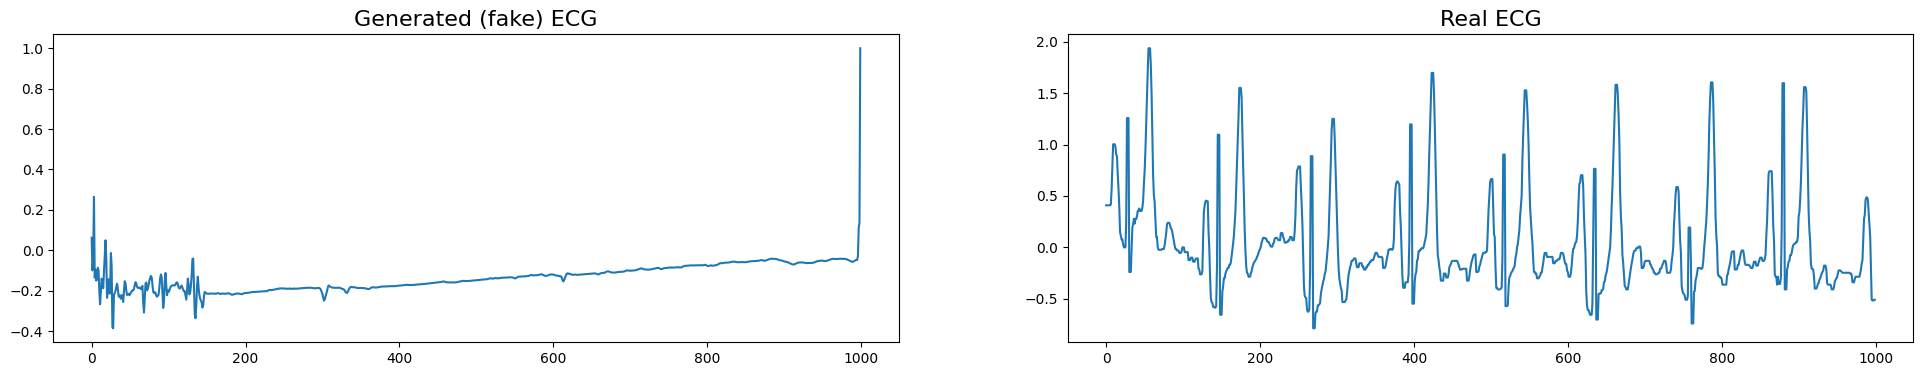

Epoch 271/2000
Generator loss: 2.218144416809082
Discriminator loss: 2296.287353515625
-------------------
Epoch 272/2000
Generator loss: 1.9367527961730957
Discriminator loss: 2107.273193359375
-------------------
Epoch 273/2000
Generator loss: 2.421416997909546
Discriminator loss: 4182.83154296875
-------------------
Epoch 274/2000
Generator loss: 2.23341703414917
Discriminator loss: 2495.604248046875
-------------------
Epoch 275/2000
Generator loss: 2.116208791732788
Discriminator loss: 4258.5029296875
-------------------
Epoch 276/2000
Generator loss: 2.081693172454834
Discriminator loss: 1511.1024169921875
-------------------
Epoch 277/2000
Generator loss: 2.424567222595215
Discriminator loss: 3724.743896484375
-------------------
Epoch 278/2000
Generator loss: 2.1085824966430664
Discriminator loss: 3504.705078125
-------------------
Epoch 279/2000
Generator loss: 2.2037553787231445
Discriminator loss: 1686.1376953125
-------------------
Epoch 280/2000
Generator loss: 2.343268632

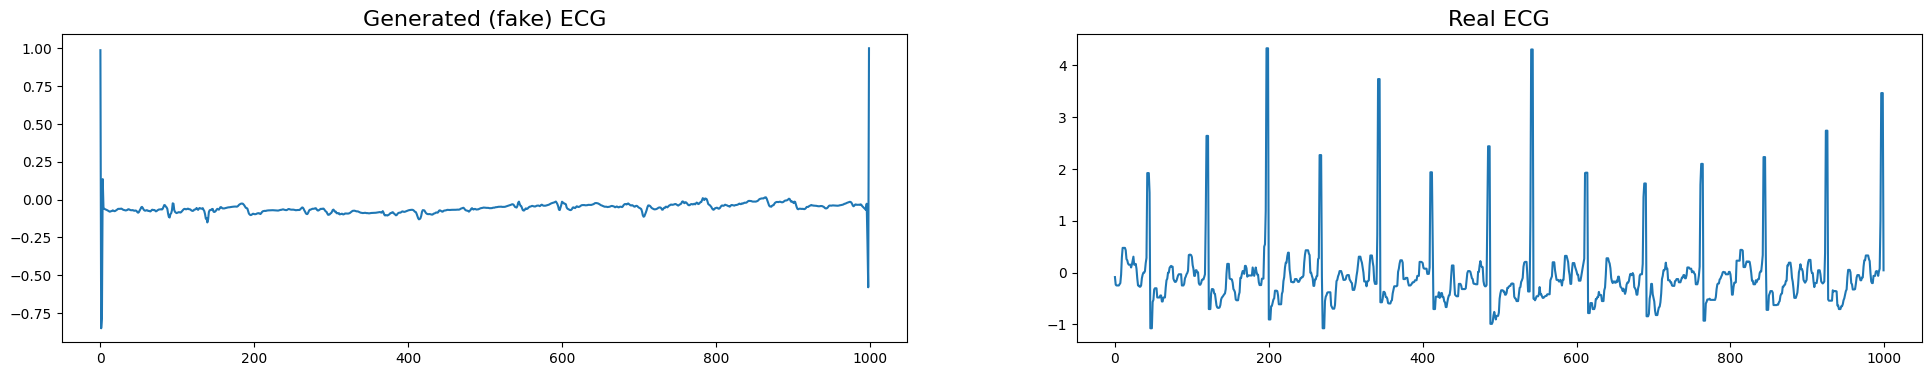

Epoch 281/2000
Generator loss: 2.141108989715576
Discriminator loss: 7888.05859375
-------------------
Epoch 282/2000
Generator loss: 2.176089286804199
Discriminator loss: 4494.84033203125
-------------------
Epoch 283/2000
Generator loss: 2.3141212463378906
Discriminator loss: 6659.623046875
-------------------
Epoch 284/2000
Generator loss: 2.2777676582336426
Discriminator loss: 5807.33203125
-------------------
Epoch 285/2000
Generator loss: 2.4542605876922607
Discriminator loss: 4933.8349609375
-------------------
Epoch 286/2000
Generator loss: 2.1190788745880127
Discriminator loss: 2581.348876953125
-------------------
Epoch 287/2000
Generator loss: 2.2807705402374268
Discriminator loss: 6412.8798828125
-------------------
Epoch 288/2000
Generator loss: 2.1589066982269287
Discriminator loss: 3989.9853515625
-------------------
Epoch 289/2000
Generator loss: 2.225402355194092
Discriminator loss: 2943.2236328125
-------------------
Epoch 290/2000
Generator loss: 2.3048887252807617
D

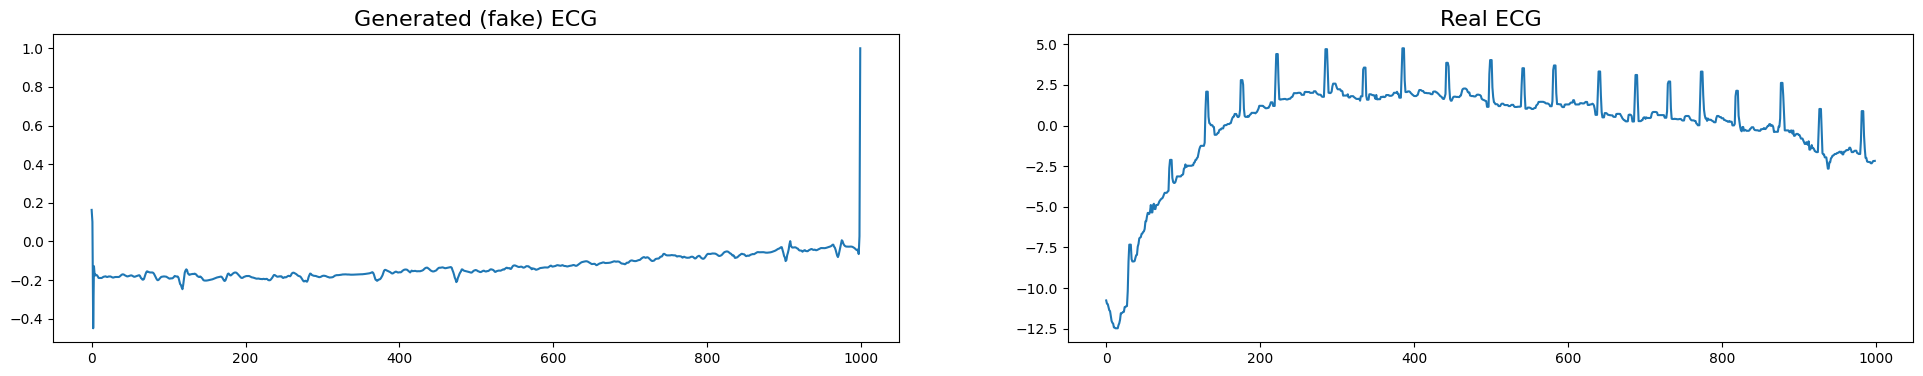

Epoch 291/2000
Generator loss: 2.1260170936584473
Discriminator loss: 3949.7109375
-------------------
Epoch 292/2000
Generator loss: 2.480093002319336
Discriminator loss: 3048.060546875
-------------------
Epoch 293/2000
Generator loss: 2.238982677459717
Discriminator loss: 5086.17333984375
-------------------
Epoch 294/2000
Generator loss: 2.255653142929077
Discriminator loss: 1443.67236328125
-------------------
Epoch 295/2000
Generator loss: 2.3176937103271484
Discriminator loss: 1571.983642578125
-------------------
Epoch 296/2000
Generator loss: 2.3107168674468994
Discriminator loss: 3005.230224609375
-------------------
Epoch 297/2000
Generator loss: 2.1508901119232178
Discriminator loss: 7657.02587890625
-------------------
Epoch 298/2000
Generator loss: 2.276552200317383
Discriminator loss: 6678.87451171875
-------------------
Epoch 299/2000
Generator loss: 2.553945779800415
Discriminator loss: 3715.22119140625
-------------------
Epoch 300/2000
Generator loss: 2.0882506370544

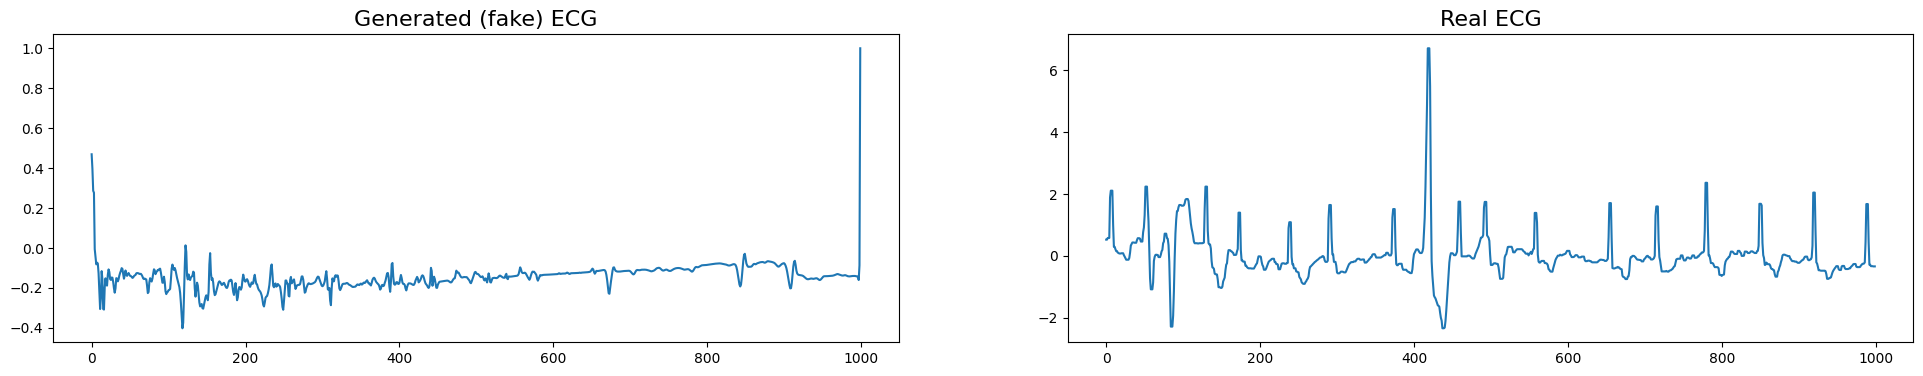

Epoch 301/2000
Generator loss: 2.2661526203155518
Discriminator loss: 4997.9326171875
-------------------
Epoch 302/2000
Generator loss: 2.1719887256622314
Discriminator loss: 3095.748291015625
-------------------
Epoch 303/2000
Generator loss: 2.2919583320617676
Discriminator loss: 6853.48779296875
-------------------
Epoch 304/2000
Generator loss: 2.0523862838745117
Discriminator loss: 2293.97265625
-------------------
Epoch 305/2000
Generator loss: 2.2434916496276855
Discriminator loss: 6962.73974609375
-------------------
Epoch 306/2000
Generator loss: 2.339663505554199
Discriminator loss: 2898.946533203125
-------------------
Epoch 307/2000
Generator loss: 2.2703683376312256
Discriminator loss: 3680.65966796875
-------------------
Epoch 308/2000
Generator loss: 2.291780948638916
Discriminator loss: 5081.41650390625
-------------------
Epoch 309/2000
Generator loss: 2.3184120655059814
Discriminator loss: 4768.7265625
-------------------
Epoch 310/2000
Generator loss: 2.354385852813

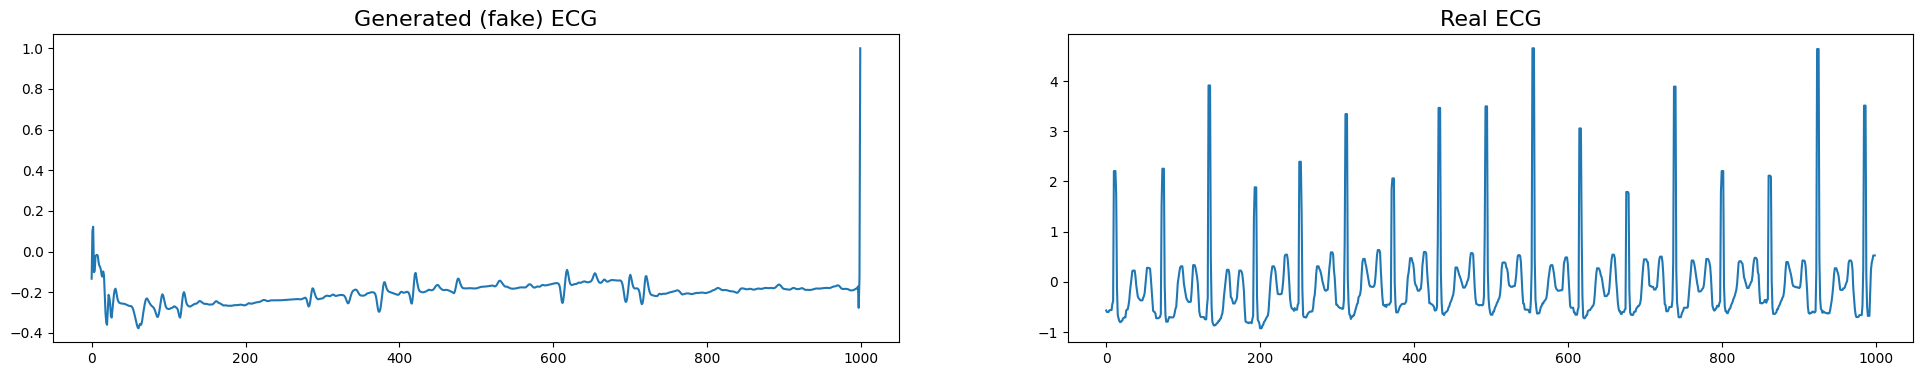

Epoch 311/2000
Generator loss: 2.2852773666381836
Discriminator loss: 6966.013671875
-------------------
Epoch 312/2000
Generator loss: 2.1037609577178955
Discriminator loss: 2269.938232421875
-------------------
Epoch 313/2000
Generator loss: 2.1778554916381836
Discriminator loss: 2447.1826171875
-------------------
Epoch 314/2000
Generator loss: 2.0855069160461426
Discriminator loss: 4180.60888671875
-------------------
Epoch 315/2000
Generator loss: 2.187223434448242
Discriminator loss: 3387.25634765625
-------------------
Epoch 316/2000
Generator loss: 2.2617528438568115
Discriminator loss: 3132.943603515625
-------------------
Epoch 317/2000
Generator loss: 2.138333559036255
Discriminator loss: 1419.568359375
-------------------
Epoch 318/2000
Generator loss: 2.3735318183898926
Discriminator loss: 6967.1435546875
-------------------
Epoch 319/2000
Generator loss: 2.172837734222412
Discriminator loss: 2311.65576171875
-------------------
Epoch 320/2000
Generator loss: 2.28188109397

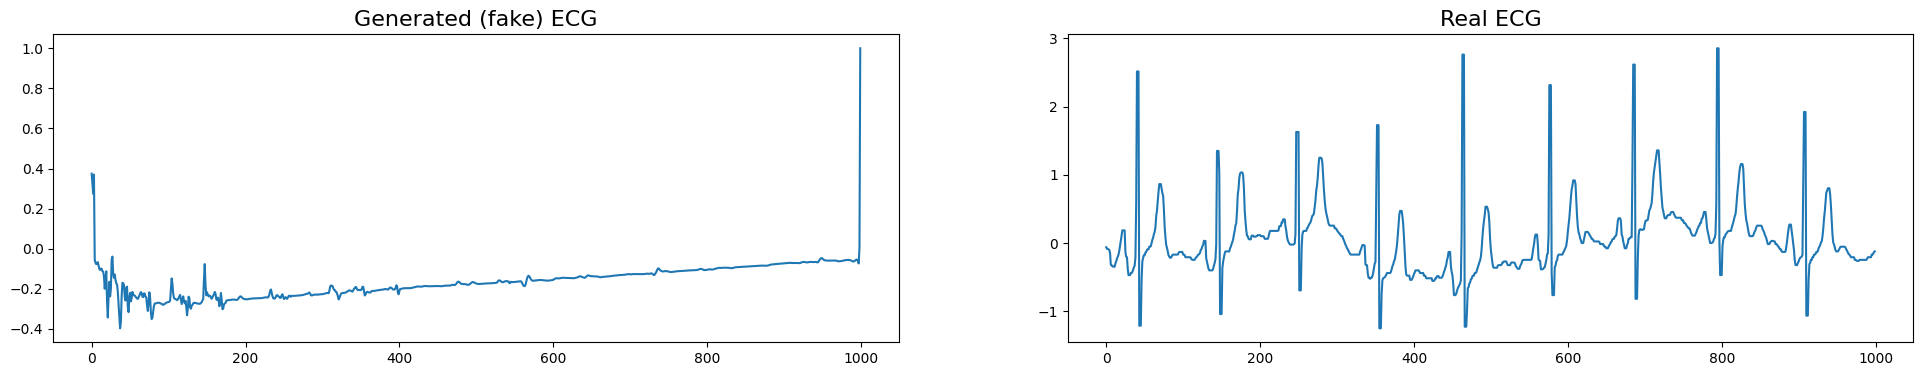

Epoch 321/2000
Generator loss: 2.113307476043701
Discriminator loss: 2361.81201171875
-------------------
Epoch 322/2000
Generator loss: 2.0230391025543213
Discriminator loss: 1840.6651611328125
-------------------
Epoch 323/2000
Generator loss: 2.0448594093322754
Discriminator loss: 2270.5625
-------------------
Epoch 324/2000
Generator loss: 2.089348316192627
Discriminator loss: 2237.34375
-------------------
Epoch 325/2000
Generator loss: 2.3481225967407227
Discriminator loss: 1429.7681884765625
-------------------
Epoch 326/2000
Generator loss: 2.279618978500366
Discriminator loss: 3935.696044921875
-------------------
Epoch 327/2000
Generator loss: 2.3033711910247803
Discriminator loss: 3301.666259765625
-------------------
Epoch 328/2000
Generator loss: 1.989835500717163
Discriminator loss: 2722.0556640625
-------------------
Epoch 329/2000
Generator loss: 2.2868096828460693
Discriminator loss: 7867.3115234375
-------------------
Epoch 330/2000
Generator loss: 2.1032190322875977


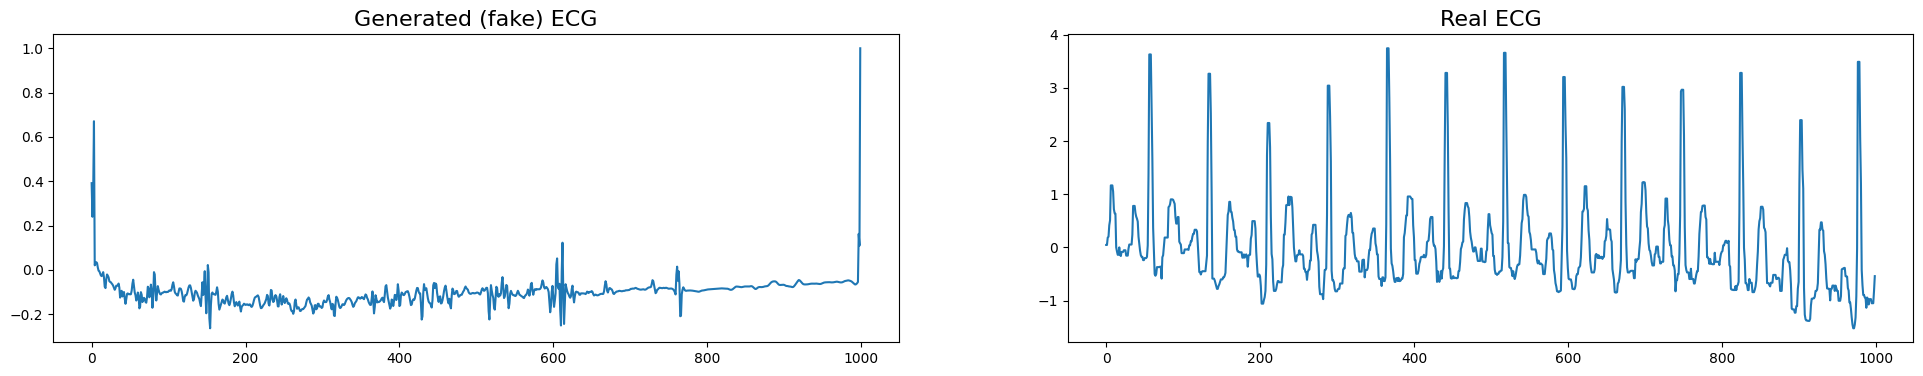

Epoch 331/2000
Generator loss: 2.355440855026245
Discriminator loss: 5141.2060546875
-------------------
Epoch 332/2000
Generator loss: 2.1401901245117188
Discriminator loss: 3807.41064453125
-------------------
Epoch 333/2000
Generator loss: 2.1622936725616455
Discriminator loss: 3804.84521484375
-------------------
Epoch 334/2000
Generator loss: 2.3230557441711426
Discriminator loss: 4232.80712890625
-------------------
Epoch 335/2000
Generator loss: 2.075693130493164
Discriminator loss: 3151.999267578125
-------------------
Epoch 336/2000
Generator loss: 2.281287670135498
Discriminator loss: 8637.5224609375
-------------------
Epoch 337/2000
Generator loss: 2.0950682163238525
Discriminator loss: 4495.60595703125
-------------------
Epoch 338/2000
Generator loss: 2.436790704727173
Discriminator loss: 3426.898681640625
-------------------
Epoch 339/2000
Generator loss: 2.3138856887817383
Discriminator loss: 8156.98291015625
-------------------
Epoch 340/2000
Generator loss: 2.05579018

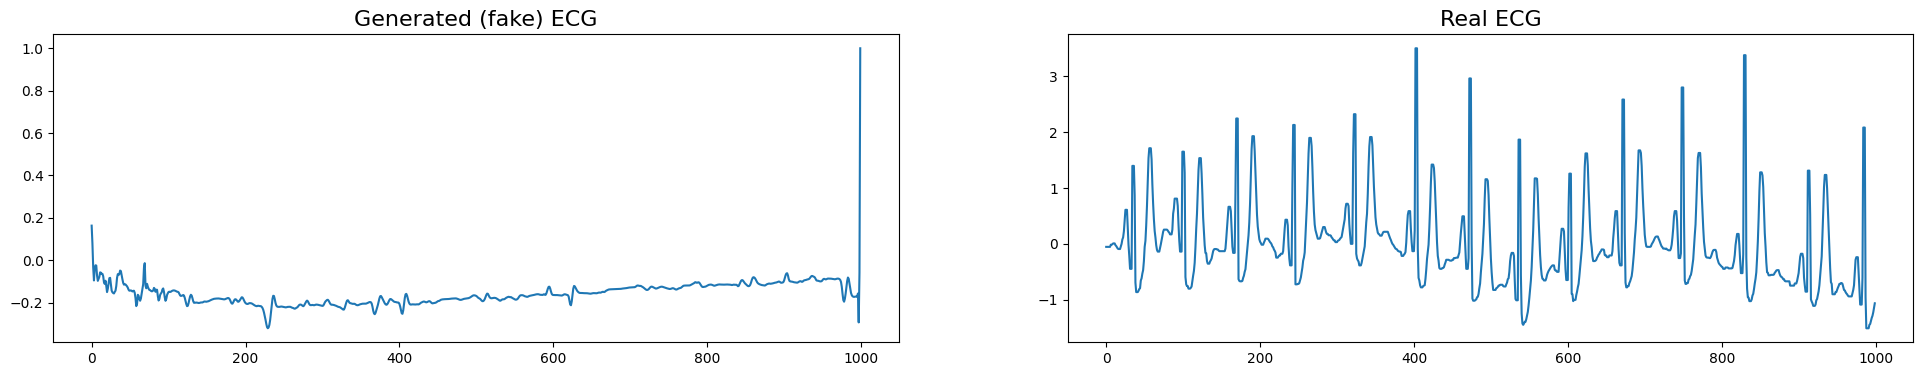

Epoch 341/2000
Generator loss: 2.3078601360321045
Discriminator loss: 6315.2421875
-------------------
Epoch 342/2000
Generator loss: 2.144697666168213
Discriminator loss: 5266.84326171875
-------------------
Epoch 343/2000
Generator loss: 2.348299026489258
Discriminator loss: 6474.4453125
-------------------
Epoch 344/2000
Generator loss: 2.4253149032592773
Discriminator loss: 7345.7978515625
-------------------
Epoch 345/2000
Generator loss: 2.210172176361084
Discriminator loss: 3683.556640625
-------------------
Epoch 346/2000
Generator loss: 2.1519343852996826
Discriminator loss: 2441.9052734375
-------------------
Epoch 347/2000
Generator loss: 2.345501184463501
Discriminator loss: 2515.926025390625
-------------------
Epoch 348/2000
Generator loss: 2.192262649536133
Discriminator loss: 10832.4521484375
-------------------
Epoch 349/2000
Generator loss: 2.196253538131714
Discriminator loss: 5744.34521484375
-------------------
Epoch 350/2000
Generator loss: 2.3804595470428467
Disc

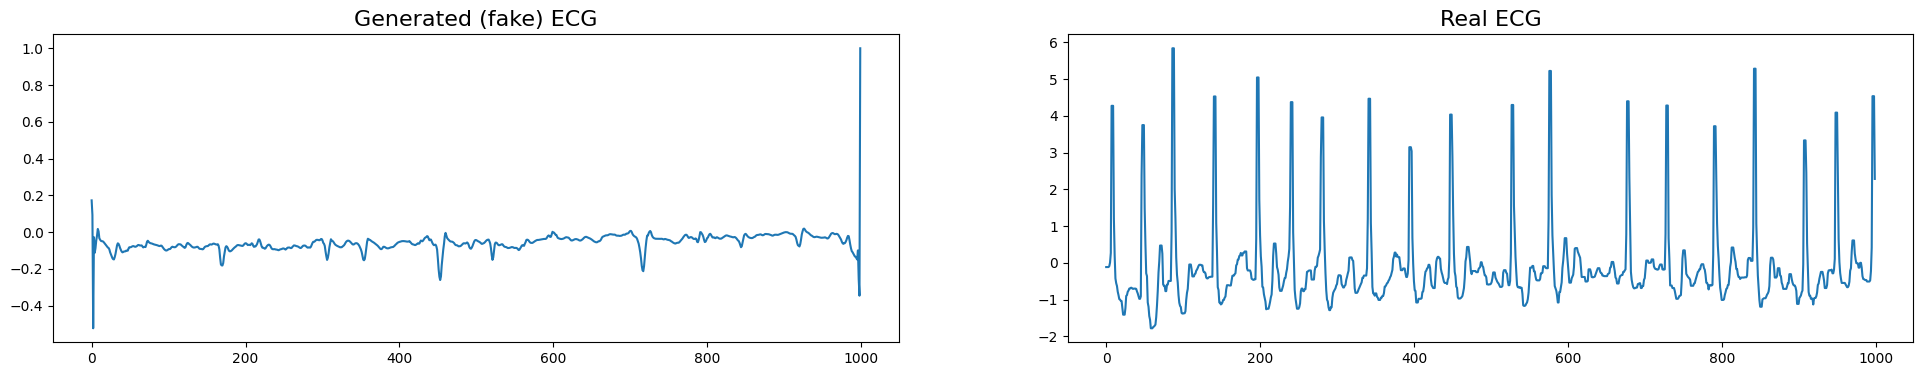

Epoch 351/2000
Generator loss: 2.130824565887451
Discriminator loss: 2156.886474609375
-------------------
Epoch 352/2000
Generator loss: 2.20859694480896
Discriminator loss: 3778.42919921875
-------------------
Epoch 353/2000
Generator loss: 2.3183767795562744
Discriminator loss: 2587.75
-------------------
Epoch 354/2000
Generator loss: 2.1119484901428223
Discriminator loss: 5832.60498046875
-------------------
Epoch 355/2000
Generator loss: 2.115892171859741
Discriminator loss: 4569.24462890625
-------------------
Epoch 356/2000
Generator loss: 2.122617244720459
Discriminator loss: 4102.48291015625
-------------------
Epoch 357/2000
Generator loss: 2.0542519092559814
Discriminator loss: 1157.781005859375
-------------------
Epoch 358/2000
Generator loss: 2.024548292160034
Discriminator loss: 6051.328125
-------------------
Epoch 359/2000
Generator loss: 2.3452048301696777
Discriminator loss: 3486.92626953125
-------------------
Epoch 360/2000
Generator loss: 2.3381540775299072
Discr

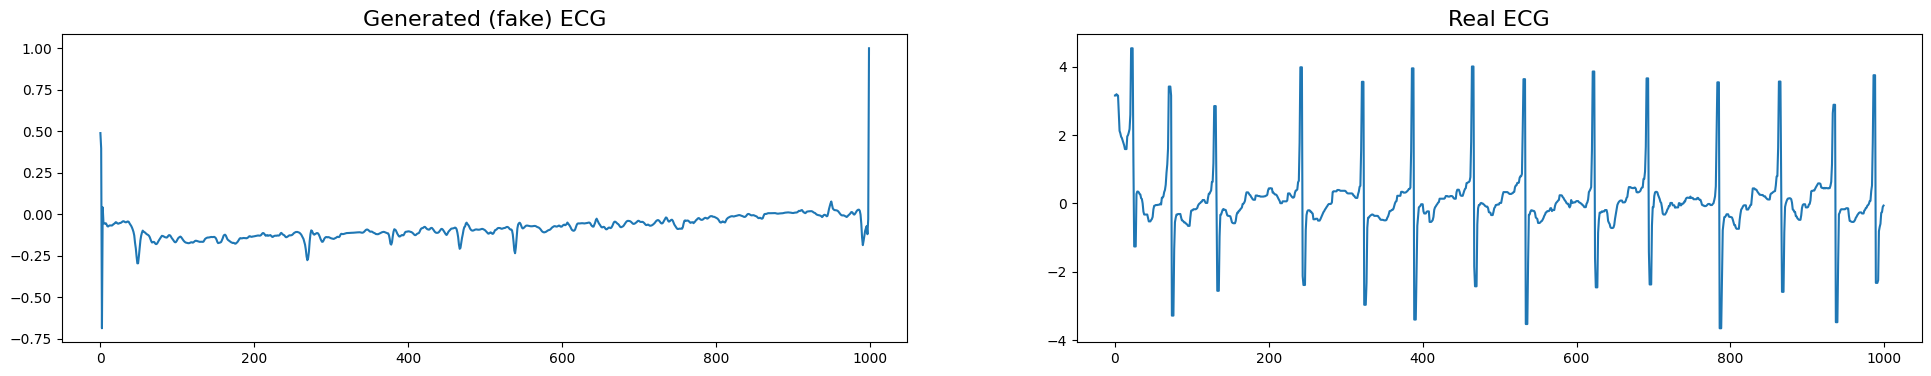

Epoch 361/2000
Generator loss: 2.124140501022339
Discriminator loss: 6767.07275390625
-------------------
Epoch 362/2000
Generator loss: 2.088221788406372
Discriminator loss: 4234.6923828125
-------------------
Epoch 363/2000
Generator loss: 2.230337142944336
Discriminator loss: 5641.96875
-------------------
Epoch 364/2000
Generator loss: 2.1546998023986816
Discriminator loss: 5956.30810546875
-------------------
Epoch 365/2000
Generator loss: 2.185448408126831
Discriminator loss: 6058.89990234375
-------------------
Epoch 366/2000
Generator loss: 2.2744436264038086
Discriminator loss: 3836.263671875
-------------------
Epoch 367/2000
Generator loss: 2.3655765056610107
Discriminator loss: 9004.6572265625
-------------------
Epoch 368/2000
Generator loss: 2.212711811065674
Discriminator loss: 3983.644287109375
-------------------
Epoch 369/2000
Generator loss: 2.2814695835113525
Discriminator loss: 6936.98486328125
-------------------
Epoch 370/2000
Generator loss: 2.602168321609497
Di

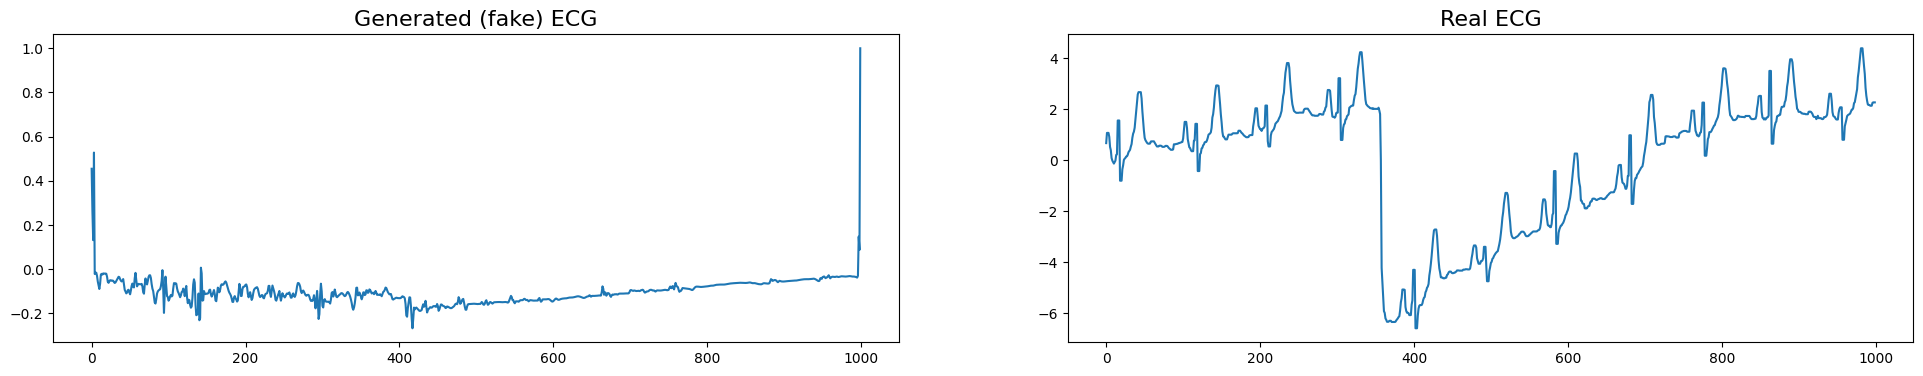

Epoch 371/2000
Generator loss: 2.2786929607391357
Discriminator loss: 7559.177734375
-------------------
Epoch 372/2000
Generator loss: 2.4182558059692383
Discriminator loss: 3992.951416015625
-------------------
Epoch 373/2000
Generator loss: 2.2229928970336914
Discriminator loss: 5893.9267578125
-------------------
Epoch 374/2000
Generator loss: 2.1554207801818848
Discriminator loss: 3749.112548828125
-------------------
Epoch 375/2000
Generator loss: 2.269759178161621
Discriminator loss: 4923.35693359375
-------------------
Epoch 376/2000
Generator loss: 2.240612745285034
Discriminator loss: 5416.43310546875
-------------------
Epoch 377/2000
Generator loss: 2.168135166168213
Discriminator loss: 2988.119873046875
-------------------
Epoch 378/2000
Generator loss: 2.066180944442749
Discriminator loss: 2035.364013671875
-------------------
Epoch 379/2000
Generator loss: 2.232274055480957
Discriminator loss: 8735.658203125
-------------------
Epoch 380/2000
Generator loss: 2.2435414791

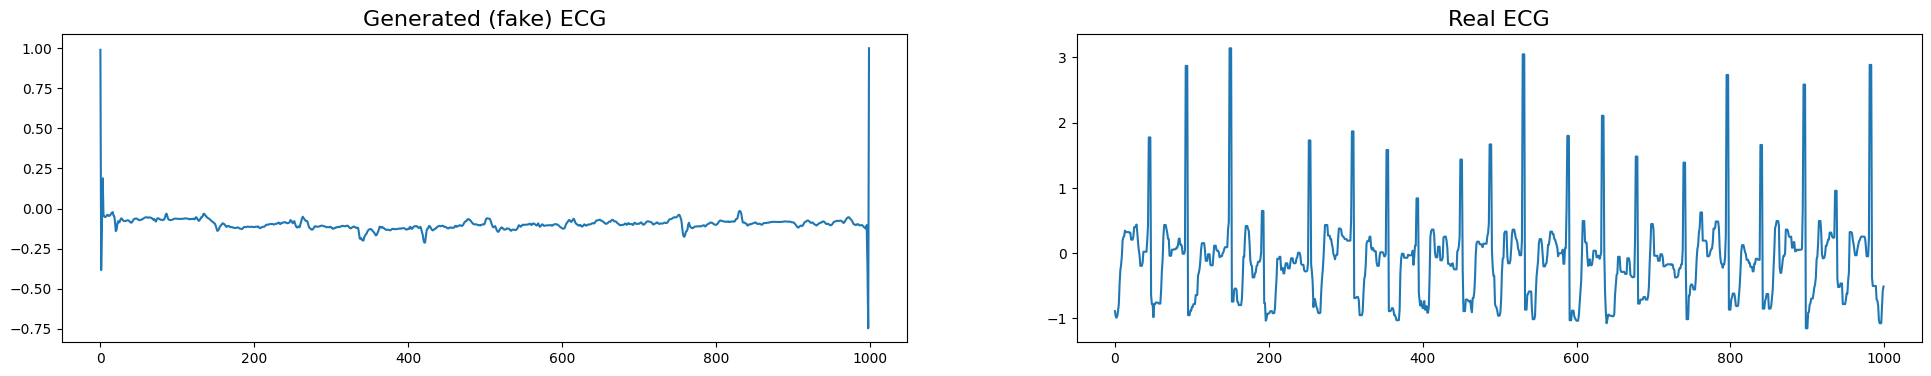

Epoch 381/2000
Generator loss: 2.223540782928467
Discriminator loss: 6016.68994140625
-------------------
Epoch 382/2000
Generator loss: 2.1897776126861572
Discriminator loss: 3941.1591796875
-------------------
Epoch 383/2000
Generator loss: 2.4722187519073486
Discriminator loss: 5370.1884765625
-------------------
Epoch 384/2000
Generator loss: 2.178447961807251
Discriminator loss: 4766.02880859375
-------------------
Epoch 385/2000
Generator loss: 2.142878532409668
Discriminator loss: 1586.16162109375
-------------------
Epoch 386/2000
Generator loss: 2.41532826423645
Discriminator loss: 4682.73583984375
-------------------
Epoch 387/2000
Generator loss: 2.239046573638916
Discriminator loss: 4381.46484375
-------------------
Epoch 388/2000
Generator loss: 2.511321783065796
Discriminator loss: 2687.734130859375
-------------------
Epoch 389/2000
Generator loss: 2.2204372882843018
Discriminator loss: 6257.314453125
-------------------
Epoch 390/2000
Generator loss: 2.187361717224121
D

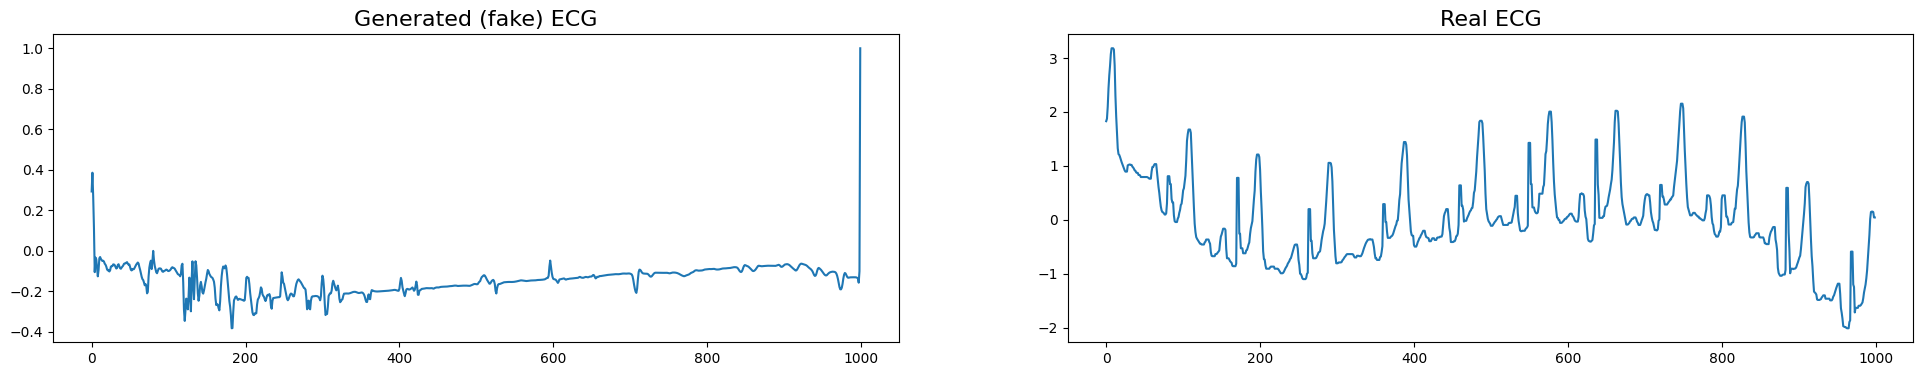

Epoch 391/2000
Generator loss: 2.399491310119629
Discriminator loss: 2520.356201171875
-------------------
Epoch 392/2000
Generator loss: 2.3819739818573
Discriminator loss: 3977.7890625
-------------------
Epoch 393/2000
Generator loss: 2.2358670234680176
Discriminator loss: 1436.679931640625
-------------------
Epoch 394/2000
Generator loss: 2.3711020946502686
Discriminator loss: 4011.912353515625
-------------------
Epoch 395/2000
Generator loss: 2.2095906734466553
Discriminator loss: 1172.1451416015625
-------------------
Epoch 396/2000
Generator loss: 2.2842342853546143
Discriminator loss: 6427.62060546875
-------------------
Epoch 397/2000
Generator loss: 2.0616915225982666
Discriminator loss: 4357.30224609375
-------------------
Epoch 398/2000
Generator loss: 2.2143492698669434
Discriminator loss: 10465.099609375
-------------------
Epoch 399/2000
Generator loss: 2.2313647270202637
Discriminator loss: 3484.240478515625
-------------------
Epoch 400/2000
Generator loss: 2.3490149

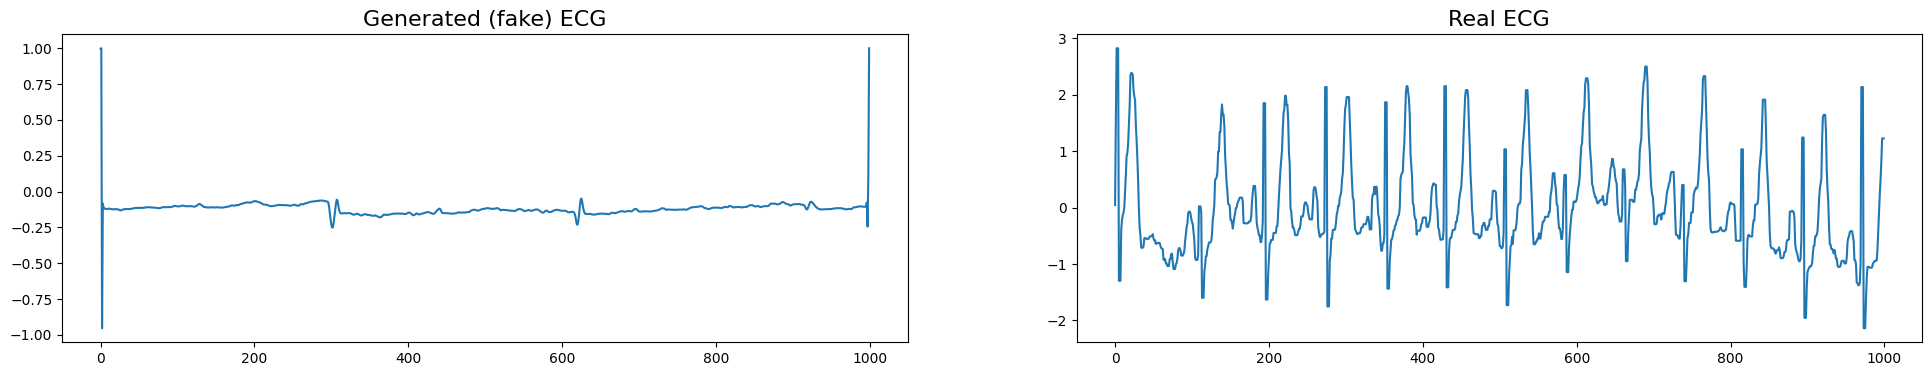

Epoch 401/2000
Generator loss: 2.1818044185638428
Discriminator loss: 2277.302734375
-------------------
Epoch 402/2000
Generator loss: 2.0180752277374268
Discriminator loss: 1638.9715576171875
-------------------
Epoch 403/2000
Generator loss: 2.261099100112915
Discriminator loss: 6749.40185546875
-------------------
Epoch 404/2000
Generator loss: 2.5352466106414795
Discriminator loss: 1203.7069091796875
-------------------
Epoch 405/2000
Generator loss: 2.294614791870117
Discriminator loss: 5785.185546875
-------------------
Epoch 406/2000
Generator loss: 2.0936901569366455
Discriminator loss: 1550.0233154296875
-------------------
Epoch 407/2000
Generator loss: 2.285426139831543
Discriminator loss: 6120.12451171875
-------------------
Epoch 408/2000
Generator loss: 2.6005473136901855
Discriminator loss: 2297.8671875
-------------------
Epoch 409/2000
Generator loss: 2.1694397926330566
Discriminator loss: 3304.55517578125
-------------------
Epoch 410/2000
Generator loss: 2.269374132

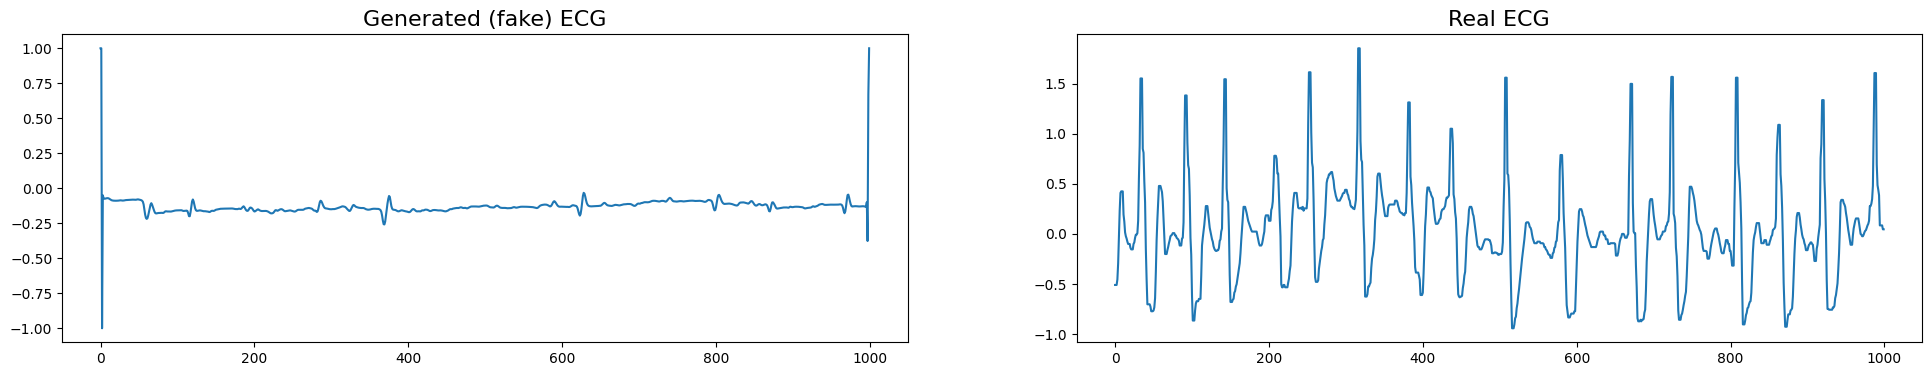

Epoch 411/2000
Generator loss: 2.0272488594055176
Discriminator loss: 3368.981689453125
-------------------
Epoch 412/2000
Generator loss: 2.159501552581787
Discriminator loss: 5404.66748046875
-------------------
Epoch 413/2000
Generator loss: 2.381422281265259
Discriminator loss: 4226.04931640625
-------------------
Epoch 414/2000
Generator loss: 2.690983772277832
Discriminator loss: 28061.587890625
-------------------
Epoch 415/2000
Generator loss: 2.4804606437683105
Discriminator loss: 12929.4931640625
-------------------
Epoch 416/2000
Generator loss: 2.028005599975586
Discriminator loss: 2431.94091796875
-------------------
Epoch 417/2000
Generator loss: 2.157937526702881
Discriminator loss: 4243.80615234375
-------------------
Epoch 418/2000
Generator loss: 2.3975679874420166
Discriminator loss: 8570.9326171875
-------------------
Epoch 419/2000
Generator loss: 2.3149659633636475
Discriminator loss: 6369.2763671875
-------------------
Epoch 420/2000
Generator loss: 2.18471336364

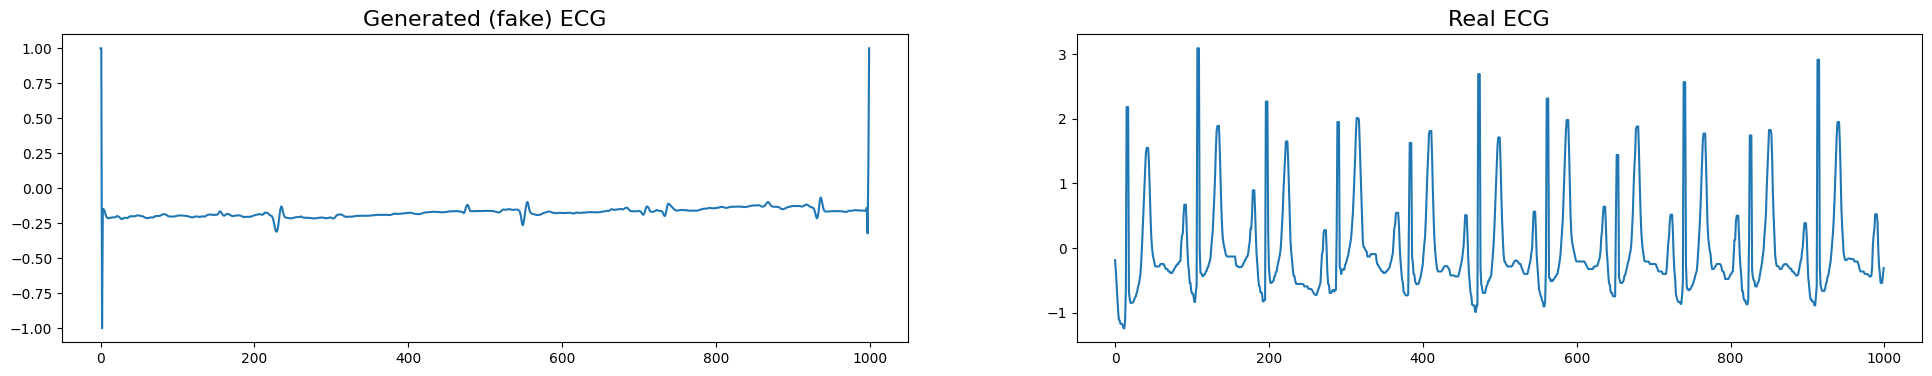

Epoch 421/2000
Generator loss: 2.57289719581604
Discriminator loss: 7753.40087890625
-------------------
Epoch 422/2000
Generator loss: 2.207024574279785
Discriminator loss: 7850.09521484375
-------------------
Epoch 423/2000
Generator loss: 2.3407301902770996
Discriminator loss: 5351.54296875
-------------------
Epoch 424/2000
Generator loss: 2.153946876525879
Discriminator loss: 2216.35498046875
-------------------
Epoch 425/2000
Generator loss: 2.3712189197540283
Discriminator loss: 2430.805908203125
-------------------
Epoch 426/2000
Generator loss: 2.298022508621216
Discriminator loss: 8457.8564453125
-------------------
Epoch 427/2000
Generator loss: 2.2852511405944824
Discriminator loss: 1623.8358154296875
-------------------
Epoch 428/2000
Generator loss: 2.2067861557006836
Discriminator loss: 2161.269775390625
-------------------
Epoch 429/2000
Generator loss: 2.3349215984344482
Discriminator loss: 4832.89453125
-------------------
Epoch 430/2000
Generator loss: 2.140479087829

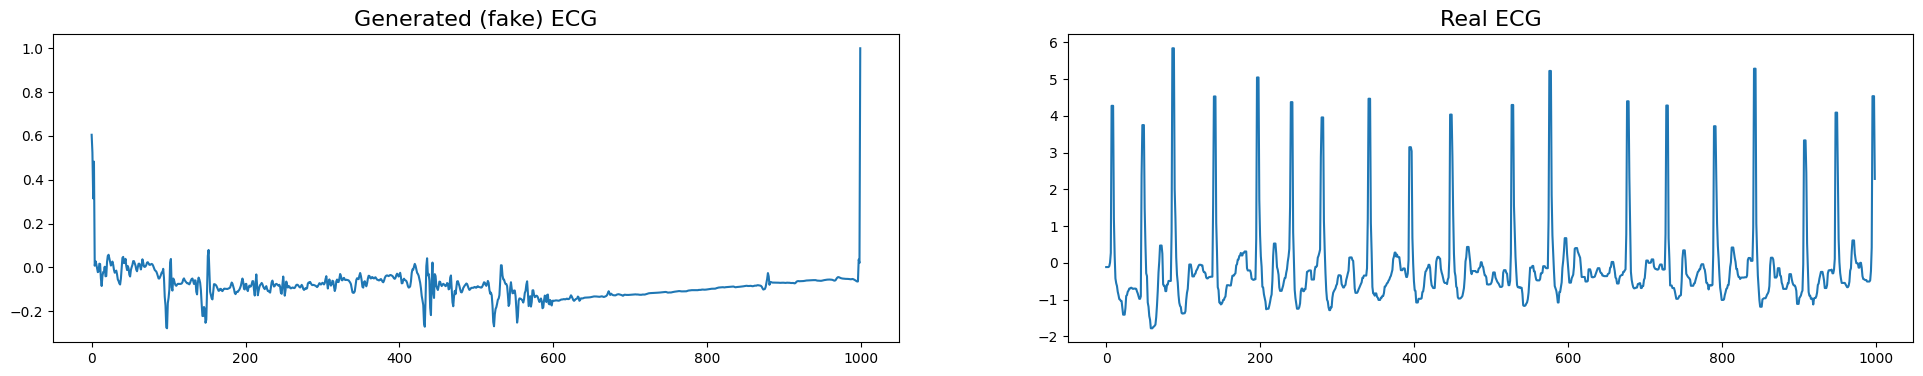

Epoch 431/2000
Generator loss: 2.297530174255371
Discriminator loss: 6582.23095703125
-------------------
Epoch 432/2000
Generator loss: 2.2376294136047363
Discriminator loss: 3051.112060546875
-------------------
Epoch 433/2000
Generator loss: 2.136889934539795
Discriminator loss: 3496.2275390625
-------------------
Epoch 434/2000
Generator loss: 2.106147050857544
Discriminator loss: 3367.34375
-------------------
Epoch 435/2000
Generator loss: 2.408356189727783
Discriminator loss: 3259.015869140625
-------------------
Epoch 436/2000
Generator loss: 2.1531615257263184
Discriminator loss: 3974.361572265625
-------------------
Epoch 437/2000
Generator loss: 2.141892910003662
Discriminator loss: 1717.0762939453125
-------------------
Epoch 438/2000
Generator loss: 2.182478189468384
Discriminator loss: 3669.610107421875
-------------------
Epoch 439/2000
Generator loss: 2.102182388305664
Discriminator loss: 3254.14208984375
-------------------
Epoch 440/2000
Generator loss: 2.144974708557

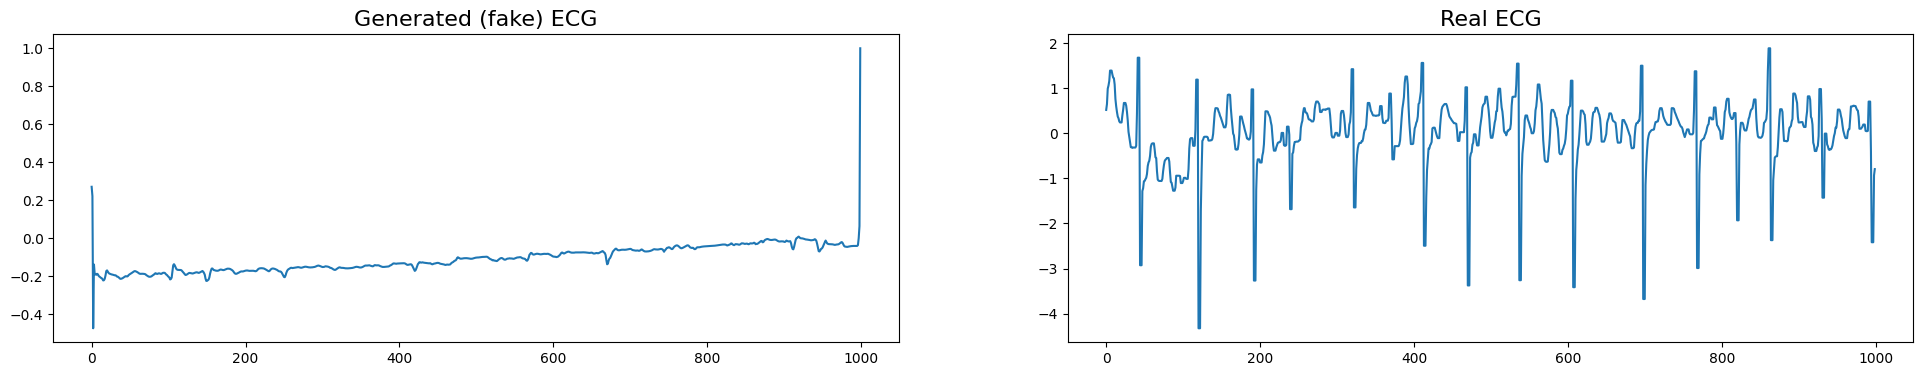

Epoch 441/2000
Generator loss: 2.390592098236084
Discriminator loss: 3555.19970703125
-------------------
Epoch 442/2000
Generator loss: 2.0363597869873047
Discriminator loss: 3278.350341796875
-------------------
Epoch 443/2000
Generator loss: 2.1616933345794678
Discriminator loss: 3151.496337890625
-------------------
Epoch 444/2000
Generator loss: 2.2879886627197266
Discriminator loss: 6465.6806640625
-------------------
Epoch 445/2000
Generator loss: 2.097100019454956
Discriminator loss: 5203.857421875
-------------------
Epoch 446/2000
Generator loss: 2.1469171047210693
Discriminator loss: 2013.126708984375
-------------------
Epoch 447/2000
Generator loss: 2.373509407043457
Discriminator loss: 6287.00244140625
-------------------
Epoch 448/2000
Generator loss: 2.2163803577423096
Discriminator loss: 5377.14306640625
-------------------
Epoch 449/2000
Generator loss: 2.2573814392089844
Discriminator loss: 3328.93603515625
-------------------
Epoch 450/2000
Generator loss: 2.5244350

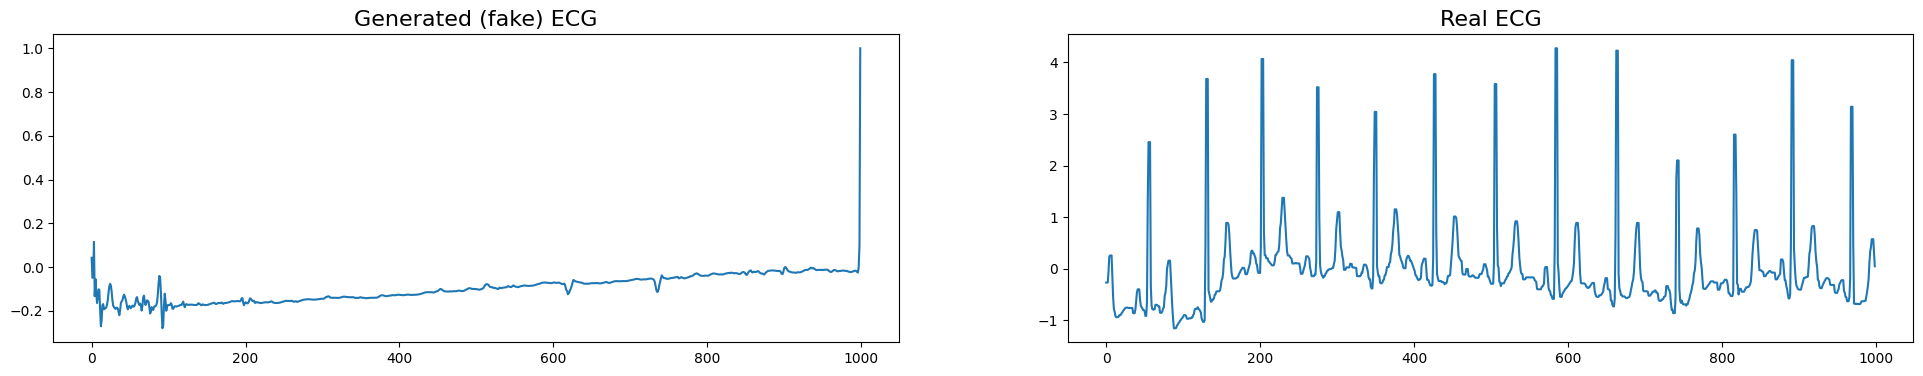

Epoch 451/2000
Generator loss: 2.1195180416107178
Discriminator loss: 3665.46044921875
-------------------
Epoch 452/2000
Generator loss: 2.299281597137451
Discriminator loss: 4062.799560546875
-------------------
Epoch 453/2000
Generator loss: 2.2090909481048584
Discriminator loss: 4571.521484375
-------------------
Epoch 454/2000
Generator loss: 2.3485639095306396
Discriminator loss: 9293.69140625
-------------------
Epoch 455/2000
Generator loss: 2.218858242034912
Discriminator loss: 3814.729248046875
-------------------
Epoch 456/2000


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error configuring GPUs: {e}")
else:
    print("No GPUs available.")
tf.debugging.set_log_device_placement(True)
clip_value = 5.0  

# Define optimizers with gradient clipping
opt_gen = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=clip_value)
opt_desc = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=clip_value)


# Updated train step
def train_step(real_data, labels, feature_extractor=None):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake data
        generated_data = con_gen([noise, labels], training=True)

        # Get discriminator outputs
        real_output = con_desc([real_data, labels], training=True)
        fake_output = con_desc([generated_data, labels], training=True)
        real_output = real_output[0] if isinstance(real_output, list) else real_output
        fake_output = fake_output[0] if isinstance(fake_output, list) else fake_output

        # Smooth labels for training stability
        y_real_smooth = smooth_positive_labels(tf.ones_like(real_output)* 0.9)  # Same shape as real_output
        y_fake_smooth = smooth_negative_labels(tf.zeros_like(fake_output))  # Same shape as fake_output

        # Discriminator Loss
        disc_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_real_smooth, real_output))
        disc_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_fake_smooth, fake_output))
        
        # Apply gradient penalty (WGAN)
        loss_gp = gradient_penalty_layer(real_data, generated_data, labels)
        disc_loss = disc_loss_real + disc_loss_fake + 3.0 * loss_gp  # Reduced gradient penalty

        # Generator Loss
        gen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))
  
        # Add Temporal Coherence Loss to Generator Loss
        tc_loss = temporal_coherence_loss(real_data, generated_data)
        gen_loss += tc_loss  # Add temporal coherence loss to the generator's total loss
        
        # Feature Matching Loss
        gen_loss += feature_matching_loss(real_output, fake_output)
        
        # DTW Loss
        dtw_loss_value = dtw_loss(real_data, generated_data)
        gen_loss += dtw_loss_value  # Add DTW loss to generator's total loss

        # Waveform-Specific Loss
        waveform_loss_value = waveform_specific_loss(real_data, generated_data)
        gen_loss += waveform_loss_value  # Add waveform-specific loss to generator's total loss

        # Correlation Loss
        correlation_loss_value = calculate_correlation(real_data, generated_data)
        gen_loss += correlation_loss_value  # Add correlation loss to generator's total loss

        # FID Loss (if feature extractor is provided)
        if feature_extractor is not None:
            fid_loss_value = calculate_fid(real_data, generated_data, feature_extractor)
            gen_loss += fid_loss_value  # Add FID loss to generator's total loss

    # Compute Gradients
    gradients_of_gen = gen_tape.gradient(gen_loss, con_gen.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, con_desc.trainable_variables)

    # Apply Gradients with clipping
    opt_gen.apply_gradients(zip(gradients_of_gen, con_gen.trainable_variables))
    opt_desc.apply_gradients(zip(gradients_of_disc, con_desc.trainable_variables))

    return gen_loss, disc_loss


# Training Loop 
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    for step in range(steps_per_epoch):
        # Generate real samples
        x_real, y_real = generate_real_samples(ECGs, y_train, batch_size)
        x_real_tensor = tf.convert_to_tensor(x_real, dtype=tf.float32)
        y_real_tensor = tf.convert_to_tensor(y_real, dtype=tf.float32)

        # Perform a training step
        gen_loss, disc_loss = train_step(x_real_tensor, y_real_tensor, feature_extractor)

        # Train the generator again (twice per discriminator update)
        gen_loss_2, _ = train_step(x_real_tensor, y_real_tensor, feature_extractor)

        # Call the reduce learning rate callback manually after each epoch
        reduce_lr_gen.on_epoch_end(epoch, logs={'loss': gen_loss.numpy()})
        reduce_lr_desc.on_epoch_end(epoch, logs={'loss': disc_loss.numpy()})

        # Store losses for tracking
        accu_loss_gan.append(gen_loss)      
        accu_loss_desc.append(disc_loss)
    # Print the losses for the epoch
    print(f"Generator loss: {gen_loss.numpy()}")
    print(f"Discriminator loss: {disc_loss.numpy()}")
    print("-------------------")

    # Call the reduce learning rate callback manually after each epoch
    reduce_lr_gen.on_epoch_end(epoch, logs={'loss': gen_loss.numpy()})
    reduce_lr_desc.on_epoch_end(epoch, logs={'loss': disc_loss.numpy()})

    # Save generator and discriminator models periodically
    if (epoch + 1) % 10 == 0:
        res = con_gen.predict([generate_latent_points(latent_dim, 1), tf.convert_to_tensor(np.array([[0]]), dtype=tf.float32)], verbose=0)
        compare_real_and_gen_ecg(res, ECGs)

    # Save weights every 2000 epochs
    if (epoch + 1) % 3000 == 0:
        gen_save_path = os.path.join('/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data', f'inspectionmodel_generator_epoch_{epoch + 1}.weights.h5')
        desc_save_path = os.path.join('/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data', f'inspectionmodel_discriminator_epoch_{epoch + 1}.weights.h5')

        con_gen.save_weights(gen_save_path)
        con_desc.save_weights(desc_save_path)

        print(f'Saved generator weights to: {gen_save_path}')
        print(f'Saved discriminator weights to: {desc_save_path}')


In [ ]:
# Evaluation Function
def evaluate_generator(generator, ECGs, y_val, latent_dim, feature_extractor):
    # Ensure that the labels are tensors
    y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

    # Generate random noise for the generator's input
    noise = tf.random.normal([ECGs.shape[0], latent_dim])

    # Combine the noise and the labels into a single input tensor
    inputs = [noise, y_val_tensor]

    # Generate samples using the generator
    generated_data = generator(inputs, training=False)

    # Compute the different evaluation metrics
    tc_loss = temporal_coherence_loss(ECGs, generated_data)
    fid = calculate_fid(ECGs, generated_data, feature_extractor)
    dtw = dtw_loss(ECGs, generated_data)
    waveform_loss = waveform_specific_loss(ECGs, generated_data)
    correlation = calculate_correlation(ECGs, generated_data)

    # Return the metrics in a dictionary
    metrics = {
        'Temporal Coherence Loss': tc_loss.numpy(),
        'FID': fid,
        'DTW Loss': dtw.numpy(),
        'Waveform-Specific Loss': waveform_loss.numpy(),
        'Correlation': correlation.numpy()
    }
    
    return metrics


In [44]:
def calculate_correlation(real_data, generated_data):
    # Flatten data to compute correlation across the full signal
    real_flat = tf.reshape(real_data, [real_data.shape[0], -1])
    gen_flat = tf.reshape(generated_data, [generated_data.shape[0], -1])

    # Compute mean and standard deviation
    real_mean = tf.cast(tf.reduce_mean(real_flat, axis=1), dtype=tf.float32)  # Cast to float32
    gen_mean = tf.cast(tf.reduce_mean(gen_flat, axis=1), dtype=tf.float32)  # Cast to float32
    real_std = tf.math.reduce_std(real_flat, axis=1)
    gen_std = tf.math.reduce_std(gen_flat, axis=1)

    # Compute covariance and correlation coefficient
    covariance = tf.reduce_mean((real_flat - real_mean[:, None]) * (gen_flat - gen_mean[:, None]), axis=1)
    correlation = covariance / (real_std * gen_std + 1e-10)  # Avoid division by zero

    return tf.reduce_mean(correlation)

def calculate_correlation(real_data, generated_data):
    # Ensure all tensors are float32
    real_data = tf.cast(real_data, dtype=tf.float32)
    generated_data = tf.cast(generated_data, dtype=tf.float32)

    # Flatten data to compute correlation across the full signal
    real_flat = tf.reshape(real_data, [real_data.shape[0], -1])
    gen_flat = tf.reshape(generated_data, [generated_data.shape[0], -1])

    # Compute mean and standard deviation
    real_mean = tf.reduce_mean(real_flat, axis=1)
    gen_mean = tf.reduce_mean(gen_flat, axis=1)

    # Ensure both means are the same type as the input tensors (i.e., float32)
    real_mean = tf.cast(real_mean, dtype=tf.float32)
    gen_mean = tf.cast(gen_mean, dtype=tf.float32)

    real_std = tf.math.reduce_std(real_flat, axis=1)
    gen_std = tf.math.reduce_std(gen_flat, axis=1)

    # Compute covariance and correlation coefficient
    covariance = tf.reduce_mean((real_flat - real_mean[:, None]) * (gen_flat - gen_mean[:, None]), axis=1)
    correlation = covariance / (real_std * gen_std + 1e-10)  # Avoid division by zero

    return tf.reduce_mean(correlation)



In [45]:
# Evaluate the generator on validation/test data
validation_metrics = evaluate_generator(con_gen, ECGs_val, y_val, latent_dim, feature_extractor)

# Print the evaluation results
print("Validation Metrics:")
for metric, value in validation_metrics.items():
    print(f"{metric}: {value}")

Validation Metrics:
Temporal Coherence Loss: 0.1747789978981018
FID: 0.5421765690605241
DTW Loss: 1.1956429481506348
Waveform-Specific Loss: 1.1956429481506348
Correlation: 0.0034441614989191294


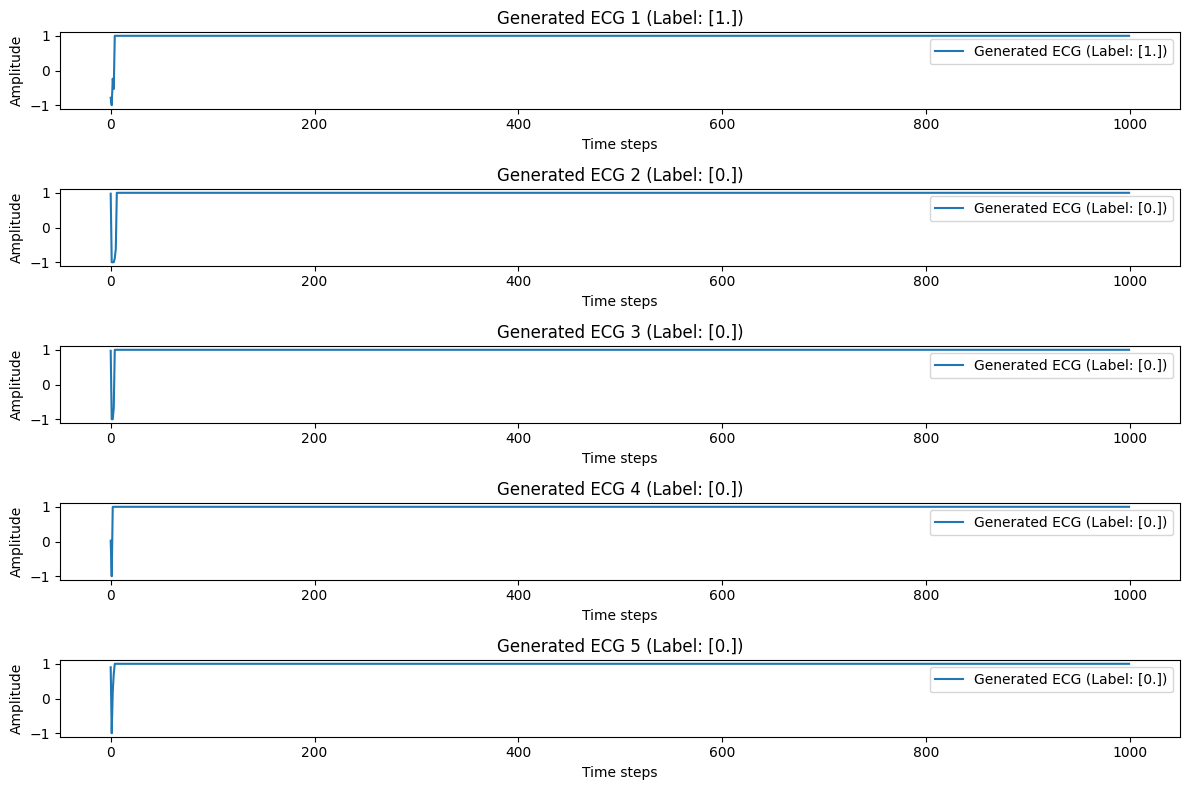

In [46]:
def plot_generated_ecgs(generator, real_labels, num_samples=5):
    noise = tf.random.normal([num_samples, latent_dim])
    labels = real_labels[:num_samples]  # Use the first 'num_samples' labels
    generated_data = generator([noise, labels], training=False)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(generated_data[i].numpy().squeeze(), label=f"Generated ECG (Label: {labels[i].numpy()})")
        plt.title(f"Generated ECG {i + 1} (Label: {labels[i].numpy()})")
        plt.xlabel("Time steps")
        plt.ylabel("Amplitude")
        plt.legend()
    plt.tight_layout()
    plt.show()
# Use real labels from your dataset
real_labels = tf.convert_to_tensor(y_val[:5], dtype=tf.float32)  # Use the first 5 validation labels
plot_generated_ecgs(con_gen, real_labels)


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_discriminator_after_training(discriminator, generator, real_data, real_labels, latent_dim, batch_size):
    """
    Evaluate the discriminator after training.
    
    Parameters:
        discriminator (Model): The trained discriminator model.
        generator (Model): The trained generator model.
        real_data (np.array or tf.Tensor): Real samples.
        real_labels (np.array or tf.Tensor): Labels for real samples (e.g., 1).
        latent_dim (int): Dimensionality of the generator's latent space.
        batch_size (int): Batch size for generating fake samples.
    
    Returns:
        dict: A dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Generate fake samples
    noise = tf.random.normal([len(real_labels), latent_dim])  # Match the size of real_labels
    fake_data = generator([noise, real_labels], training=False)
    fake_labels = tf.zeros_like(real_labels)  # Fake labels are zeros

    # Concatenate real and fake data
    combined_data = tf.concat([real_data, fake_data], axis=0)
    combined_labels = tf.concat([real_labels, fake_labels], axis=0)
    
    # Get discriminator predictions
    predictions = discriminator([combined_data, combined_labels], training=False)
    predictions = predictions[0] if isinstance(predictions, list) else predictions  # Handle multi-output models
    predictions = tf.squeeze(predictions).numpy()  # Flatten predictions
    
    # Convert probabilities to binary predictions
    pred_classes = (predictions > 0.5).astype(int)
    
    # Calculate evaluation metrics
    true_classes = combined_labels.numpy().astype(int)
    accuracy = accuracy_score(true_classes, pred_classes)
    precision = precision_score(true_classes, pred_classes)
    recall = recall_score(true_classes, pred_classes)
    f1 = f1_score(true_classes, pred_classes)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Example usage after training
print("Evaluating Discriminator Post-Training...")
eval_results = evaluate_discriminator_after_training(
    discriminator=con_desc,
    generator=con_gen,
    real_data=x_real_tensor,
    real_labels=y_real_tensor,
    latent_dim=latent_dim,
    batch_size=batch_size
)

print("Discriminator Evaluation Results:")
print(f"  Accuracy: {eval_results['accuracy']:.4f}")
print(f"  Precision: {eval_results['precision']:.4f}")
print(f"  Recall: {eval_results['recall']:.4f}")
print(f"  F1 Score: {eval_results['f1_score']:.4f}")
